In [5]:
import os 
import sys
from tqdm import tqdm
import importlib
import numpy as np
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt

module_path = "/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/"
model_save_dir = '/home/lun/project-basileus/multitype-sequence-generation-by-tlstm-gan/models/combined-gs-sine'

if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
BATCH_SIZE = 256
T = 20
VOCAB = ['A', 'B', 'C', 'D']
EVENT_VOCAB_DIM = len(VOCAB)
EMB_DIM = 16
HIDDEN_DIM = 128

In [8]:
def create_dataset(features: np.array, labels: np.array, batch_size=2, epochs=10, buffer_size=10000):
    """
    Create dataset from numpy arrays
    """
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset


def generate_initial_noise(max_token=EVENT_VOCAB_DIM, time_mean=0, time_std=1):
    init_token_noise_index = tf.random.uniform(shape=[BATCH_SIZE, 1, 1], maxval=max_token, dtype=tf.int32)
    init_token_noise = tf.squeeze(tf.one_hot(init_token_noise_index, EVENT_VOCAB_DIM, axis=2, dtype=tf.float64), axis=3)
    init_time_noise = tf.random.truncated_normal(shape=[BATCH_SIZE, 1, 1], mean=time_mean, stddev=time_std, dtype=tf.float64)
    return init_token_noise, init_time_noise

## Use Sine-Wave as train data

In [9]:
phase = []
phase.append([i % 4 for i in range(T)])
phase.append([(i+1) % 4 for i in range(T)])
phase.append([(i+2) % 4 for i in range(T)])
phase.append([(i+3) % 4 for i in range(T)]) 
phase = tf.convert_to_tensor(phase, dtype=tf.float64)

# cast indicator data into one-hot
phase_ind = tf.cast(phase, dtype=tf.int32)
event_type_unit = tf.one_hot(phase_ind, depth=4, axis=2, dtype=tf.float64)
time_stamp_unit = tf.math.sin(np.pi / 2 * phase)

In [10]:
pos_event_type_seqs = tf.repeat(event_type_unit, 1000, axis=0)

pos_timestamp_seqs = tf.repeat(time_stamp_unit, 1000, axis=0)
pos_timestamp_seqs += tf.random.normal(shape=pos_timestamp_seqs.shape, mean=0, stddev=0.1, dtype=tf.float64)
pos_timestamp_seqs = tf.expand_dims(pos_timestamp_seqs, axis=-1)

## Create multitype SeqGan

In [11]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Activation, Multiply, Add, Lambda
from tensorflow.keras import regularizers

from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

tf.keras.backend.set_floatx('float64')

def build_G(batch_size, event_vocab_dim, emb_dim, hidden_dim=16):
    # inputs of Time-LSTM:
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp

    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)

    hm = LSTM(hidden_dim,
          name='lstm_token',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)

    
    tm = LSTM(hidden_dim,
          name='lstm_time',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
    
    token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dense_combined = Dense(hidden_dim, 
                           activation='elu',
                           name='dense_combination')(token_time_comb)
        
    token_logits = Dense(event_vocab_dim,
                   activation='linear',
                   name='dense_token',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
        
    time_delta_out = Dense(1,
                   activation='linear',
                   name='dense_time',
                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
                   bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(dense_combined)
    
    generator = Model(
        inputs=[i_et, i_ts],
        outputs=[token_logits, time_delta_out])
        
    return generator

In [12]:
def build_D(batch_size, T, event_vocab_dim, emb_dim, hidden_dim, dropout_rate=0.25):
    # normal LSTM
    i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
    i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp
    
    embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
    merged0 = tf.concat([embed0, i_ts], axis=2)
    
    hm = LSTM(hidden_dim,
          name='lstm_token',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)

    tm = LSTM(hidden_dim,
          name='lstm_time',
          stateful=True,
          return_sequences=False,
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
    token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
    dropped = Dropout(rate=dropout_rate)(token_time_comb)
    
    prob = Dense(1, 
             activation='sigmoid',
             name='final',
             kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
             bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)
        
    discriminator = Model(
        inputs=[i_et, i_ts],
        outputs=prob)
    return discriminator

In [13]:
# import tensorflow as tf
# from tensorflow.keras import backend as K
# from tensorflow.keras.models import Model
# from tensorflow.keras import Sequential
# from tensorflow.keras.optimizers import Adam, SGD
# from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense, Dropout, Activation, Multiply, Add, Lambda
# from tensorflow.keras import regularizers

# from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

# tf.keras.backend.set_floatx('float64')

# def build_G(batch_size, event_vocab_dim, emb_dim, hidden_dim=16):
#     # inputs of Time-LSTM:
#     i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
#     i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp

#     embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
#     merged0 = tf.concat([embed0, i_ts], axis=2)
    
#     hm, tm = TimeLSTM1(hidden_dim,
#                        name='time_lstm',
#                        stateful=True, 
#                        return_sequences=False,
#                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        time_kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)    
        
#     token_logits = Dense(event_vocab_dim,
#                    activation='linear',
#                    name='dense_token',
#                    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                    bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(hm)
        
#     time_delta_out = Dense(1,
#                    activation='linear',
#                    name='dense_time',
#                    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                    bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(tm)
    
#     generator = Model(
#         inputs=[i_et, i_ts],
#         outputs=[token_logits, time_delta_out])
        
#     return generator

In [14]:
# def build_D(batch_size, T, event_vocab_dim, emb_dim, hidden_dim, dropout_rate=0.25):
#     # normal LSTM
#     i_et = Input(batch_shape=(batch_size, None, event_vocab_dim), name='event_type')  # input of discrete feature event type
#     i_ts = Input(batch_shape=(batch_size, None, 1), name='time_delta_in')  # input of continuous feature timestamp
    
#     embed0 = Dense(emb_dim, name='dense_emb')(i_et) # dense matrix size: 6*16
#     merged0 = tf.concat([embed0, i_ts], axis=2)
    
#     hm, tm = TimeLSTM1(hidden_dim,
#                        name='time_lstm',
#                        stateful=True, 
#                        return_sequences=False,
#                        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        recurrent_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        time_kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),
#                        bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))(merged0)
    
#     token_time_comb = tf.keras.layers.concatenate([hm, tm], axis=1)
    
#     dropped = Dropout(rate=dropout_rate)(token_time_comb)
    
#     prob = Dense(1, 
#              activation='sigmoid',
#              name='final',
#              kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None),
#              bias_initializer=tf.keras.initializers.Constant(value=0.1))(dropped)
        
#     discriminator = Model(
#         inputs=[i_et, i_ts],
#         outputs=prob)
#     return discriminator

## Define rollout and sequence generation

In [30]:
def sample_gumbel(shape, eps=1e-20): 
    U = tf.random.uniform(shape,minval=0,maxval=1)   #gumbel noise
#     print('noise:{}'.format(U))
    return -tf.math.log(-tf.math.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature=0.5): 
    y = logits + tf.cast(sample_gumbel(tf.shape(logits)), logits.dtype)
    return tf.nn.softmax( y / temperature)  # use softmax to approximate argmax

def gumbel_softmax(logits, temperature=0.5, hard=True):
    """Sample from the Gumbel-Softmax distribution and optionally discretize.
    Args:
    logits: [batch_size, n_class] unnormalized log-probs
    temperature: non-negative scalar
    hard: if True, take argmax, but differentiate w.r.t. soft sample y
    Returns:
    [batch_size, n_class] sample from the Gumbel-Softmax distribution.
    If hard=True, then the returned sample will be one-hot, otherwise it will
    be a probabilitiy distribution that sums to 1 across classes
    """
    logits = tf.cast(logits, tf.float64)
    y = gumbel_softmax_sample(logits, temperature) # this is differentiable
    if hard:
        k = tf.shape(logits)[-1]
        #y_hard = tf.cast(tf.one_hot(tf.argmax(y,1),k), y.dtype)
        y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,1,keepdims=True)),y.dtype)
        y = tf.stop_gradient(y_hard - y) + y
    return y


In [31]:
def rollout_from_initial_gumbel(G, batch_size, init_et, init_ts, L=T):
    # Begin from dummy init state (init_token=1, init_timestamp=0.0)
    all_state_et = init_et
    all_state_ts = init_ts
    
    l_prefix = init_et.shape[1]
    
    G.reset_states()
#     # LSTM-token
#     G.layers[4].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
#     G.layers[4].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
#     # LSTM-time
#     G.layers[5].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
#     G.layers[5].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
    
    # Time-LSTM
#     G.layers[4].states[0] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))
#     G.layers[4].states[1] = tf.Variable(tf.random.normal(shape=(BATCH_SIZE, HIDDEN_DIM), mean=0.0, stddev=1, dtype=tf.float64))

    for _ in range(L + 1 - l_prefix):  # sequence length
        curr_state_et = all_state_et[:, -1:, :]
        curr_state_ts = all_state_ts[:, -1:, :]
        
        # add step noise to token and time inputs
#         curr_state_et = tf.cast(tf.where(curr_state_et == 1, 0.9, 0.1/3), tf.float64)
#         curr_state_ts = curr_state_ts + tf.random.truncated_normal(shape=tf.shape(curr_state_ts), mean=0.0, stddev=1, dtype=tf.float64)

        token_logits, time_delta_out = G([curr_state_et, curr_state_ts])
        
        # sample event types using Gumbel-softmax
        sampled_et = gumbel_softmax(token_logits, temperature=0.9)  # this is differentiable
        sampled_et = tf.reshape(sampled_et, [batch_size, 1, EVENT_VOCAB_DIM])        
        sampled_et = tf.cast(sampled_et, dtype=tf.float64) # cast sampled_et into float
        
        time_delta_out = tf.reshape(time_delta_out, [batch_size, 1, 1]) 
        
        # Do NOT stop genererating once hit end_token; G is supposed to learn it.
        all_state_et = tf.concat([all_state_et, sampled_et], axis=1)
        all_state_ts = tf.concat([all_state_ts, time_delta_out], axis=1)

    # the initlal random states are excluded in output
    return all_state_et[:, 1:, :], all_state_ts[:, 1:, :]


def generate_sequences_gumbel(N_gen, generator, batch_size, T):
    """
        Generate sequences batch per batch
    :param N_gen: total number of seqs to be generated
    :param generator:
    :param batch_size:
    :param T:
    :return: a python list of shape [N_gen, T, 1]
    """
    N = 0
    all_type_seq = None
    all_time_seq = None
    
    init_token_noise, init_time_noise = generate_initial_noise()
        
    while N < N_gen:
        batch_state_et, batch_state_ts = rollout_from_initial_gumbel(generator, batch_size, init_token_noise, init_time_noise, T)

        if all_type_seq is None or all_time_seq is None:
            all_type_seq = batch_state_et
            all_time_seq = batch_state_ts
        else:
            all_type_seq = tf.concat([all_type_seq, batch_state_et], axis=0)
            all_time_seq = tf.concat([all_time_seq, batch_state_ts], axis=0)

        N += batch_size

    all_type_seq = all_type_seq[:N_gen, :, :]
    all_time_seq = all_time_seq[:N_gen, :, :]

    return all_type_seq, all_time_seq

## Pre-Training of Gumbel-Softmax SeqGan

In [32]:
def pretrain_discriminator(event_type_batch, time_delta_batch, label_batch, discriminator, verbose=False, optimizer=Adam(lr=0.001)):
    # train the discriminator
    with tf.GradientTape() as tape:
        # train discriminator
        true_prob = discriminator([event_type_batch, time_delta_batch])

        # cross-entropy loss
        discriminator_loss = ce_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(label_batch, true_prob, from_logits=False)
        )

        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss


def pretrain_generator(event_type_batch, time_delta_batch, generator, verbose=False, optimizer=Adam(lr=0.001)):
    _, T, _ = event_type_batch.shape
    
    # train the generator
    with tf.GradientTape() as tape:
        generator.reset_states()
        step_token_ce_loss_list = []
        step_time_mxe_loss_list = []

        for i in range(0, T - 1):
            curr_state_et = event_type_batch[:, i:i + 1, :]
            curr_state_ts = time_delta_batch[:, i:i + 1, :]
            
            target_et = event_type_batch[:, i + 1, :]
            target_ts = time_delta_batch[:, i + 1, :]            
            
            token_logits, time_delta_out = generator([curr_state_et, curr_state_ts])

            token_ce_losses = tf.keras.losses.categorical_crossentropy(target_et, token_logits, from_logits=True)
            token_ce_loss = tf.reduce_mean(token_ce_losses)
            step_token_ce_loss_list.append(token_ce_loss)
            
            time_mxe_losses = tf.keras.losses.MAE(target_ts, time_delta_out)
            time_mxe_loss = tf.reduce_mean(time_mxe_losses)
            step_time_mxe_loss_list.append(time_mxe_loss)                        
    
        episode_token_ce_loss = tf.reduce_mean(step_token_ce_loss_list)
        episode_time_mxe_loss = tf.reduce_mean(step_time_mxe_loss_list)
        generator_loss = episode_token_ce_loss + episode_time_mxe_loss

    if verbose:
        print('token ce loss:{}'.format(episode_token_ce_loss))
        print('time mae loss:{}'.format(episode_time_mxe_loss))
        print('train loss:{}'.format(generator_loss))

    # apply gradient decent per batch
    grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return generator_loss

### pre-train G

In [33]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 1
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)

pretrain_G_dataset = create_dataset((pos_event_type_seqs, pos_timestamp_seqs),
                                  np.ones((N_total_G, 1)),
                                  batch_size=BATCH_SIZE,
                                  epochs=EPOCHS,
                                  buffer_size=N_total_G)
_TOTAL_STEPS

15

In [34]:
pretrain_gen_loss_history = []

pretrained_generator = build_G(
    batch_size=BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM)

In [35]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
# _TOTAL_STEPS = 100

for feature_batch, _ in tqdm(pretrain_G_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    step += 1
    print('Training Step:', step)
        
    gen_loss =  pretrain_generator(event_type_batch, time_delta_batch, pretrained_generator, verbose=True, optimizer=OPTIMIZER)                    
    pretrain_gen_loss_history.append(gen_loss.numpy())

0it [00:00, ?it/s]

Training Step: 1
token ce loss:1.3902541086204863
time mae loss:0.5400274970147251
train loss:1.9302816056352112


1it [00:00,  1.25it/s]

Training Step: 2
token ce loss:1.3621216198779176
time mae loss:0.6253250167085662
train loss:1.9874466365864838


2it [00:01,  1.28it/s]

Training Step: 3
token ce loss:1.3314477861132297
time mae loss:0.5611062696341985
train loss:1.892554055747428


3it [00:02,  1.30it/s]

Training Step: 4
token ce loss:1.307191940697048
time mae loss:0.4961366068517479
train loss:1.803328547548796


4it [00:03,  1.31it/s]

Training Step: 5
token ce loss:1.2840355430624313
time mae loss:0.522729286636396
train loss:1.8067648296988272


5it [00:03,  1.31it/s]

Training Step: 6
token ce loss:1.258109515131851
time mae loss:0.505239696717062
train loss:1.7633492118489131


6it [00:04,  1.31it/s]

Training Step: 7
token ce loss:1.2310411300462123
time mae loss:0.46588949982383676
train loss:1.696930629870049


7it [00:05,  1.30it/s]

Training Step: 8
token ce loss:1.2027319691987224
time mae loss:0.45481607168820454
train loss:1.657548040886927


8it [00:06,  1.31it/s]

Training Step: 9
token ce loss:1.1732082758037403
time mae loss:0.45752574069054086
train loss:1.6307340164942812


9it [00:06,  1.31it/s]

Training Step: 10
token ce loss:1.1433728242494248
time mae loss:0.4433140283322351
train loss:1.5866868525816598


10it [00:07,  1.31it/s]

Training Step: 11
token ce loss:1.1127030933532362
time mae loss:0.4123545477964222
train loss:1.5250576411496586


11it [00:08,  1.27it/s]

Training Step: 12
token ce loss:1.0809521617298405
time mae loss:0.38242413411361725
train loss:1.4633762958434577


12it [00:09,  1.29it/s]

Training Step: 13
token ce loss:1.0476385529535657
time mae loss:0.36473503560597753
train loss:1.4123735885595432


13it [00:10,  1.30it/s]

Training Step: 14
token ce loss:1.0131685781657402
time mae loss:0.35555561094085764
train loss:1.3687241891065978


14it [00:10,  1.31it/s]

Training Step: 15
token ce loss:0.976636247888831
time mae loss:0.325636290887013
train loss:1.302272538775844


15it [00:11,  1.30it/s]


In [36]:
if not os.path.exists(model_save_dir + '/pretrained_gen_weights'):
    os.makedirs(model_save_dir + '/pretrained_gen_weights')

G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
pretrained_generator.save_weights(G_save_path)

In [37]:
reload_pretrained_gen = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

reload_pretrained_gen.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_gen.load_weights(G_save_path)
reload_pretrained_gen.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_5 (TensorFlo [(256, None, 17)]    0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]        

### pre-train D

In [41]:
N_fake_D = N_real_D = N_total_G 

In [42]:
# generate fake data by G to pre-train D
fake_pos_event_type_seqs, fake_pos_timestamp_seqs = generate_sequences_gumbel(N_fake_D, pretrained_generator, BATCH_SIZE, T)

In [43]:
# generate fake data by G to pre-train D
real_pos_event_type_seqs = pos_event_type_seqs[0:N_real_D, :, :]
real_pos_timestamp_seqs = pos_timestamp_seqs[0:N_real_D, :, :]

In [45]:
N_total_D = N_fake_D + N_real_D

pretrain_D_et = tf.concat([fake_pos_event_type_seqs, real_pos_event_type_seqs], axis=0)
pretrain_D_ts = tf.concat([fake_pos_timestamp_seqs, real_pos_timestamp_seqs], axis=0)
pretrain_D_labels = tf.concat([np.zeros((N_fake_D, 1)), np.ones((N_real_D, 1))], axis=0)

EPOCHS = 1
_TOTAL_STEPS = int(EPOCHS * N_total_D / BATCH_SIZE)

pretrain_D_dataset = create_dataset((pretrain_D_et, pretrain_D_ts),
                                    pretrain_D_labels,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS,
                                    buffer_size=N_total_D) # shuffle the entire Dataset

In [46]:
pretrain_disc_token_loss_history = []

pretrained_discriminator = build_D(batch_size=BATCH_SIZE,
                                   T=T,
                                   event_vocab_dim=EVENT_VOCAB_DIM,
                                   emb_dim=EMB_DIM,
                                   hidden_dim=HIDDEN_DIM,    
                                   dropout_rate=0.25)

In [47]:
step = 0
OPTIMIZER = Adam(lr=1e-3)
# _TOTAL_STEPS = 100

for feature_batch, labels in tqdm(pretrain_D_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch
    step += 1
    print('Training Step:', step)

    disc_token_loss = pretrain_discriminator(event_type_batch, time_delta_batch, labels, pretrained_discriminator, verbose=True, optimizer=OPTIMIZER)
    pretrain_disc_token_loss_history.append(disc_token_loss.numpy())

0it [00:00, ?it/s]

Training Step: 1
total discriminator loss:0.6936458140131656


1it [00:00,  2.33it/s]

Training Step: 2
total discriminator loss:0.7026724324950697


2it [00:00,  2.45it/s]

Training Step: 3
total discriminator loss:0.6776809326956188


3it [00:01,  2.49it/s]

Training Step: 4
total discriminator loss:0.6814027101298042


4it [00:01,  2.52it/s]

Training Step: 5
total discriminator loss:0.6729702367642749


5it [00:02,  2.52it/s]

Training Step: 6
total discriminator loss:0.6722021971135008


6it [00:02,  2.54it/s]

Training Step: 7
total discriminator loss:0.6770670195961773


7it [00:02,  2.55it/s]

Training Step: 8
total discriminator loss:0.6599987440595988


8it [00:03,  2.54it/s]

Training Step: 9
total discriminator loss:0.667168565994888


9it [00:03,  2.56it/s]

Training Step: 10
total discriminator loss:0.6738475924213359


10it [00:03,  2.56it/s]

Training Step: 11
total discriminator loss:0.6384799630847374


11it [00:04,  2.55it/s]

Training Step: 12
total discriminator loss:0.6247726437448465


12it [00:04,  2.56it/s]

Training Step: 13
total discriminator loss:0.7021280336980568


13it [00:05,  2.56it/s]

Training Step: 14
total discriminator loss:0.6744136731095989


14it [00:05,  2.55it/s]

Training Step: 15
total discriminator loss:0.6144219070776231


15it [00:05,  2.56it/s]

Training Step: 16
total discriminator loss:0.6180852772383583


16it [00:06,  2.55it/s]

Training Step: 17
total discriminator loss:0.6324444024571314


17it [00:06,  2.54it/s]

Training Step: 18
total discriminator loss:0.6501454735622779


18it [00:07,  2.54it/s]

Training Step: 19
total discriminator loss:0.6031203616810366


19it [00:07,  2.54it/s]

Training Step: 20
total discriminator loss:0.6138725809952515


20it [00:07,  2.54it/s]

Training Step: 21
total discriminator loss:0.6524781520656195


21it [00:08,  2.53it/s]

Training Step: 22
total discriminator loss:0.5758397116544297


22it [00:08,  2.52it/s]

Training Step: 23
total discriminator loss:0.5668089915052617


23it [00:09,  2.52it/s]

Training Step: 24
total discriminator loss:0.5549551038853614


24it [00:09,  2.52it/s]

Training Step: 25
total discriminator loss:0.5513262526543591


25it [00:09,  2.52it/s]

Training Step: 26
total discriminator loss:0.5211777985724273


26it [00:10,  2.52it/s]

Training Step: 27
total discriminator loss:0.5128920902224552


27it [00:10,  2.53it/s]

Training Step: 28
total discriminator loss:0.5049893573608433


28it [00:11,  2.53it/s]

Training Step: 29
total discriminator loss:0.4686019650394553


29it [00:11,  2.54it/s]

Training Step: 30
total discriminator loss:0.4696411408648598


30it [00:11,  2.53it/s]

Training Step: 31
total discriminator loss:0.4278325838884345


31it [00:12,  2.53it/s]


In [48]:
if not os.path.exists(model_save_dir + '/pretrained_disc_weights'):
    os.makedirs(model_save_dir + '/pretrained_disc_weights')

D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'
pretrained_discriminator.save_weights(D_save_path)

In [49]:
reload_pretrained_disc = build_D(
    batch_size=BATCH_SIZE,
    T=T,
    event_vocab_dim=EVENT_VOCAB_DIM,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,    
    dropout_rate=0.25)

reload_pretrained_disc.build(input_shape=((BATCH_SIZE, T, 1)))
reload_pretrained_disc.load_weights(D_save_path)
reload_pretrained_disc.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_8 (TensorFlo [(256, None, 17)]    0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]        

## Gumbel  Traning

In [84]:
def train_generator_gumbel(generator, discriminator, batch_size, T, verbose=False,                   
                    optimizer=Adam(lr=0.001)):
    
    with tf.GradientTape() as tape:                        

        G_sample_et, G_sample_ts = generate_sequences_gumbel(batch_size, generator, batch_size, T)
        D_fake = discriminator([G_sample_et, G_sample_ts])

        generator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(D_fake), D_fake))
        
    if verbose:
        print('generator loss:{}'.format(generator_loss))
        print('-----------------------')

    # update generator
    generator_grads = tape.gradient(generator_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    return generator_loss


def train_discriminator_gumbel(real_data_batch_et, real_data_batch_ts, generator, discriminator, batch_size, T, verbose=False,
                        optimizer=Adam(lr=0.001), label_smoothing=False, label_flipping=False):

    # data prep
    real_labels = tf.ones((batch_size//2, 1))        
    fake_labels = tf.zeros((batch_size//2, 1))    
    
    real_data_batch_et, real_data_batch_ts = real_data_batch_et[:batch_size//2, :, :], real_data_batch_ts[:batch_size//2, :, :]    
    fake_data_batch_et, fake_data_batch_ts = generate_sequences_gumbel(batch_size//2, generator, batch_size, T)
    
    if label_smoothing:
        fake_labels = fake_labels + tf.random.normal(fake_labels.shape, mean=0, stddev=0.3)
        fake_labels = tf.clip_by_value(fake_labels, clip_value_min=0., clip_value_max=0.3)

        real_labels = real_labels + tf.random.normal(real_labels.shape, mean=0, stddev=0.3)
        real_labels = tf.clip_by_value(real_labels, clip_value_min=0.7, clip_value_max=1.0)

    if label_flipping:
        if tf.random.uniform((1,)) < 0.05:
            fake_labels, real_labels = real_labels, fake_labels
    
    total_data_et = tf.concat([fake_data_batch_et, real_data_batch_et], axis=0)
    total_data_ts = tf.concat([fake_data_batch_ts, real_data_batch_ts], axis=0)
    total_labels = tf.concat([fake_labels, real_labels], axis=0)        
        
    # train the discriminator
    with tf.GradientTape() as tape:                                                           
        # train discriminator
        pred_prob = discriminator([total_data_et, total_data_ts])

        # cross-entropy loss
        discriminator_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(total_labels, pred_prob, from_logits=False))

        # average true return
        average_true_return = tf.reduce_mean(pred_prob)
        
        if verbose:
            print('total discriminator loss:{}'.format(discriminator_loss))
            print('average true return:{}'.format(average_true_return))
            print('-----------------------')

    grads = tape.gradient(discriminator_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    return discriminator_loss, average_true_return

In [85]:
G_save_path = model_save_dir + '/pretrained_gen_weights/model.tf'
D_save_path = model_save_dir + '/pretrained_disc_weights/model.tf'

G = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)

G.build(input_shape=((BATCH_SIZE, T, 1)))
G.load_weights(G_save_path)
G.summary()

D = build_D(
    batch_size=BATCH_SIZE,
    T=T,
    event_vocab_dim=EVENT_VOCAB_DIM,
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,    
    dropout_rate=0.25)

D.build(input_shape=((BATCH_SIZE, T, 1)))
D.load_weights(D_save_path)
D.summary()

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
event_type (InputLayer)         [(256, None, 4)]     0                                            
__________________________________________________________________________________________________
dense_emb (Dense)               (256, None, 16)      80          event_type[0][0]                 
__________________________________________________________________________________________________
time_delta_in (InputLayer)      [(256, None, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_26 (TensorFl [(256, None, 17)]    0           dense_emb[0][0]                  
                                                                 time_delta_in[0][0]       

In [86]:
N_total_G = pos_event_type_seqs.shape[0]

EPOCHS = 100
_TOTAL_STEPS = int(EPOCHS * N_total_G / BATCH_SIZE)


train_dataset = create_dataset((pos_event_type_seqs, pos_timestamp_seqs),
                             np.ones((N_total_G, 1)),
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             buffer_size=N_total_G)

gen_loss_history = []
disc_loss_history = []
average_true_return_history = []

step = 0

G_optimizer = Adam(learning_rate=1e-3)
D_optimizer = Adam(learning_rate=1e-4)

_G_STEPS = 1
_D_STEPS = 1

0it [00:00, ?it/s]

Training Step: 0
generator loss:1.3356168182252401
-----------------------
total discriminator loss:0.6561655534202371
average true return:0.6724170713138837
-----------------------
tf.Tensor([[1 2 1 2 3 1 1 0 1 3 2 0 1 1 2 2 3 2 0 3]], shape=(1, 20), dtype=int64)


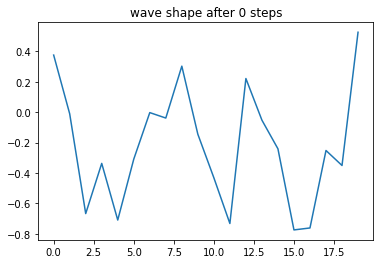

1it [00:04,  4.09s/it]

Training Step: 1
generator loss:0.40230777849157434
-----------------------
total discriminator loss:0.997803791865336
average true return:0.729005153573719
-----------------------


2it [00:07,  3.41s/it]

Training Step: 2
generator loss:0.41697778913264694
-----------------------
total discriminator loss:0.7997293081886865
average true return:0.7435241524033086
-----------------------


3it [00:09,  3.20s/it]

Training Step: 3
generator loss:0.13020284598182774
-----------------------
total discriminator loss:1.2003867879764567
average true return:0.7536998161898999
-----------------------


4it [00:12,  3.10s/it]

Training Step: 4
generator loss:0.20515271313340588
-----------------------
total discriminator loss:1.251474862534009
average true return:0.8788389533020241
-----------------------


5it [00:15,  3.08s/it]

Training Step: 5
generator loss:0.1343350405460109
-----------------------
total discriminator loss:0.8888271230389582
average true return:0.8539380612168336
-----------------------


6it [00:18,  3.05s/it]

Training Step: 6
generator loss:0.12011219260280374
-----------------------
total discriminator loss:1.3289011329213085
average true return:0.8738890018722104
-----------------------


7it [00:21,  3.04s/it]

Training Step: 7
generator loss:0.10069988703605076
-----------------------
total discriminator loss:1.4293782363924736
average true return:0.8617156772512309
-----------------------


8it [00:24,  3.03s/it]

Training Step: 8
generator loss:0.09045084730853505
-----------------------
total discriminator loss:1.42521719833441
average true return:0.8650206044991474
-----------------------


9it [00:27,  3.02s/it]

Training Step: 9
generator loss:0.08504502573722986
-----------------------
total discriminator loss:1.4540271664470916
average true return:0.8632462154416145
-----------------------


10it [00:30,  3.01s/it]

Training Step: 10
generator loss:0.08420200867344294
-----------------------
total discriminator loss:0.867502841524276
average true return:0.860750911830048
-----------------------


11it [00:33,  2.99s/it]

Training Step: 11
generator loss:0.08640669985003743
-----------------------
total discriminator loss:1.3826801048551607
average true return:0.8539781894743005
-----------------------


12it [00:36,  2.99s/it]

Training Step: 12
generator loss:0.09184638818092913
-----------------------
total discriminator loss:1.3252934221707813
average true return:0.8452344334330787
-----------------------


13it [00:40,  3.06s/it]

Training Step: 13
generator loss:0.10067094439001371
-----------------------
total discriminator loss:0.838244161438678
average true return:0.8355498919060917
-----------------------


14it [00:43,  3.03s/it]

Training Step: 14
generator loss:0.10921358662564222
-----------------------
total discriminator loss:1.2101941105800222
average true return:0.8244361393472117
-----------------------


15it [00:46,  3.02s/it]

Training Step: 15
generator loss:0.11875376765320411
-----------------------
total discriminator loss:1.170902244856164
average true return:0.8121874623241716
-----------------------


16it [00:49,  3.02s/it]

Training Step: 16
generator loss:0.12761822683727433
-----------------------
total discriminator loss:1.1299686000104712
average true return:0.798937006906036
-----------------------


17it [00:52,  3.01s/it]

Training Step: 17
generator loss:0.1362589089126202
-----------------------
total discriminator loss:1.121373744632593
average true return:0.7904446541438892
-----------------------


18it [00:55,  3.01s/it]

Training Step: 18
generator loss:0.14600344922267894
-----------------------
total discriminator loss:1.0799684768284692
average true return:0.778913837615389
-----------------------


19it [00:58,  3.01s/it]

Training Step: 19
generator loss:0.1547164257369973
-----------------------
total discriminator loss:1.0745858145880773
average true return:0.7688852698855984
-----------------------


20it [01:01,  3.00s/it]

Training Step: 20
generator loss:0.1631215256167856
-----------------------
total discriminator loss:1.05726930816834
average true return:0.7580443374219576
-----------------------


21it [01:04,  3.00s/it]

Training Step: 21
generator loss:0.17198256999956163
-----------------------
total discriminator loss:1.0289419771279897
average true return:0.7512794388452703
-----------------------


22it [01:07,  3.00s/it]

Training Step: 22
generator loss:0.18171962301332778
-----------------------
total discriminator loss:0.699163343532269
average true return:0.7461354265387108
-----------------------


23it [01:10,  2.99s/it]

Training Step: 23
generator loss:0.19106864897532394
-----------------------
total discriminator loss:1.0005598512155407
average true return:0.7335039809640181
-----------------------


24it [01:13,  2.98s/it]

Training Step: 24
generator loss:0.2015862364505982
-----------------------
total discriminator loss:0.988459830727718
average true return:0.7247711366261194
-----------------------


25it [01:15,  2.98s/it]

Training Step: 25
generator loss:0.2121791764014481
-----------------------
total discriminator loss:0.9517567272564539
average true return:0.7132239893658151
-----------------------
tf.Tensor([[0 1 0 2 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1]], shape=(1, 20), dtype=int64)


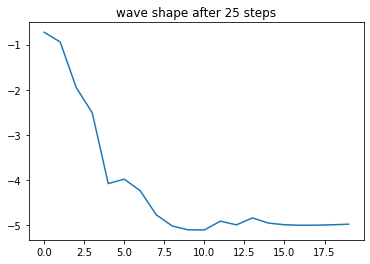

26it [01:19,  3.23s/it]

Training Step: 26
generator loss:0.22488940429485763
-----------------------
total discriminator loss:0.6777727754452958
average true return:0.7060908758071962
-----------------------


27it [01:22,  3.13s/it]

Training Step: 27
generator loss:0.23634653174194198
-----------------------
total discriminator loss:0.9234307025353832
average true return:0.6952103145602162
-----------------------


28it [01:25,  3.09s/it]

Training Step: 28
generator loss:0.24963008324870234
-----------------------
total discriminator loss:0.8972213782951554
average true return:0.6833544623028038
-----------------------


29it [01:28,  3.05s/it]

Training Step: 29
generator loss:0.2631512284173275
-----------------------
total discriminator loss:0.8934455615856991
average true return:0.6750073366070644
-----------------------


30it [01:31,  3.03s/it]

Training Step: 30
generator loss:0.2775749831282699
-----------------------
total discriminator loss:0.8705159874518399
average true return:0.6690092605258473
-----------------------


31it [01:34,  3.02s/it]

Training Step: 31
generator loss:0.2926311638295771
-----------------------
total discriminator loss:0.8485243730272511
average true return:0.6610496477198758
-----------------------


32it [01:37,  3.08s/it]

Training Step: 32
generator loss:0.3091643077994701
-----------------------
total discriminator loss:0.828200963245653
average true return:0.6562139354488347
-----------------------


33it [01:40,  3.05s/it]

Training Step: 33
generator loss:0.32555496458083244
-----------------------
total discriminator loss:0.8124665429154878
average true return:0.6501214812251844
-----------------------


34it [01:43,  3.03s/it]

Training Step: 34
generator loss:0.3419240039372374
-----------------------
total discriminator loss:0.78652662723068
average true return:0.6466757309831523
-----------------------


35it [01:46,  3.01s/it]

Training Step: 35
generator loss:0.3591659038151437
-----------------------
total discriminator loss:0.764229211210843
average true return:0.6431019696505667
-----------------------


36it [01:49,  2.98s/it]

Training Step: 36
generator loss:0.3760146643245016
-----------------------
total discriminator loss:0.7374530957391904
average true return:0.6413524440742769
-----------------------


37it [01:52,  2.97s/it]

Training Step: 37
generator loss:0.3915340259066366
-----------------------
total discriminator loss:0.7342183189067938
average true return:0.6383985317722869
-----------------------


38it [01:55,  2.96s/it]

Training Step: 38
generator loss:0.40631301726079794
-----------------------
total discriminator loss:0.7286278491605855
average true return:0.6361216201995779
-----------------------


39it [01:58,  2.96s/it]

Training Step: 39
generator loss:0.4172144089415696
-----------------------
total discriminator loss:0.7152349186942724
average true return:0.635915366635766
-----------------------


40it [02:01,  2.95s/it]

Training Step: 40
generator loss:0.4238474402382637
-----------------------
total discriminator loss:0.7222165388405747
average true return:0.635364078907033
-----------------------


41it [02:04,  2.96s/it]

Training Step: 41
generator loss:0.41541296226113383
-----------------------
total discriminator loss:0.7403794651811538
average true return:0.6439719051130192
-----------------------


42it [02:07,  2.97s/it]

Training Step: 42
generator loss:0.3902144095163718
-----------------------
total discriminator loss:0.7788743965637707
average true return:0.6520541699934087
-----------------------


43it [02:10,  2.96s/it]

Training Step: 43
generator loss:0.394757319153317
-----------------------
total discriminator loss:0.7661023966697434
average true return:0.6450777029072413
-----------------------


44it [02:13,  2.96s/it]

Training Step: 44
generator loss:0.40656298964258586
-----------------------
total discriminator loss:0.7524560860844888
average true return:0.6392332925879645
-----------------------


45it [02:16,  3.00s/it]

Training Step: 45
generator loss:0.42092648421679246
-----------------------
total discriminator loss:0.7485304315379983
average true return:0.6370543835632985
-----------------------


46it [02:19,  2.99s/it]

Training Step: 46
generator loss:0.43477210083985196
-----------------------
total discriminator loss:0.7332507922942743
average true return:0.6330761571767187
-----------------------


47it [02:22,  2.98s/it]

Training Step: 47
generator loss:0.4462230508652717
-----------------------
total discriminator loss:0.7236818901432645
average true return:0.6365534916834934
-----------------------


48it [02:25,  2.97s/it]

Training Step: 48
generator loss:0.45958469494638643
-----------------------
total discriminator loss:0.7007981407289818
average true return:0.6409693924927062
-----------------------


49it [02:28,  2.97s/it]

Training Step: 49
generator loss:0.4725240104483671
-----------------------
total discriminator loss:0.6739299512037173
average true return:0.6428848066125878
-----------------------


50it [02:31,  2.97s/it]

Training Step: 50
generator loss:0.48853949266024427
-----------------------
total discriminator loss:0.6716284141914937
average true return:0.6481487356796085
-----------------------
tf.Tensor([[0 1 1 1 0 1 1 2 0 1 1 1 1 1 0 1 1 1 3 0]], shape=(1, 20), dtype=int64)


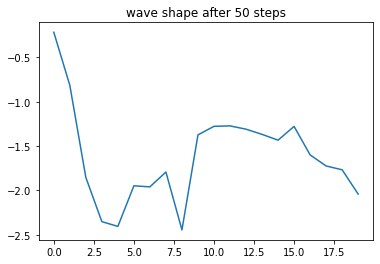

51it [02:35,  3.23s/it]

Training Step: 51
generator loss:0.5055519627315175
-----------------------
total discriminator loss:0.6519595521109048
average true return:0.6465344393433616
-----------------------


52it [02:38,  3.22s/it]

Training Step: 52
generator loss:0.5281374742794078
-----------------------
total discriminator loss:0.61723595444902
average true return:0.6463450889505071
-----------------------


53it [02:41,  3.15s/it]

Training Step: 53
generator loss:0.5473348634471593
-----------------------
total discriminator loss:0.5966319360031843
average true return:0.6404719450476752
-----------------------


54it [02:44,  3.08s/it]

Training Step: 54
generator loss:0.5695392331361705
-----------------------
total discriminator loss:0.5883104168877838
average true return:0.6321233042826631
-----------------------


55it [02:47,  3.05s/it]

Training Step: 55
generator loss:0.5878123606935239
-----------------------
total discriminator loss:0.9204850803279452
average true return:0.6241676562650099
-----------------------


56it [02:50,  3.03s/it]

Training Step: 56
generator loss:0.5965503494292804
-----------------------
total discriminator loss:0.5852790821893694
average true return:0.6171168578802285
-----------------------


57it [02:53,  3.01s/it]

Training Step: 57
generator loss:0.6057204854687959
-----------------------
total discriminator loss:0.5855920773402796
average true return:0.6077791768063221
-----------------------


58it [02:56,  2.99s/it]

Training Step: 58
generator loss:0.6077347944071949
-----------------------
total discriminator loss:0.5923976580944481
average true return:0.601232951298865
-----------------------


59it [02:58,  2.97s/it]

Training Step: 59
generator loss:0.6098305710256737
-----------------------
total discriminator loss:0.6087447238255845
average true return:0.5956818131806717
-----------------------


60it [03:01,  2.96s/it]

Training Step: 60
generator loss:0.6093253417912877
-----------------------
total discriminator loss:0.6221384363934453
average true return:0.5858385076875829
-----------------------


61it [03:04,  2.94s/it]

Training Step: 61
generator loss:0.6063886759405076
-----------------------
total discriminator loss:0.641110043762776
average true return:0.5812577928832492
-----------------------


62it [03:07,  2.95s/it]

Training Step: 62
generator loss:0.6162454189882934
-----------------------
total discriminator loss:0.6635951354789379
average true return:0.5660841290678384
-----------------------


63it [03:10,  2.95s/it]

Training Step: 63
generator loss:0.6173509032608898
-----------------------
total discriminator loss:0.6725494207348364
average true return:0.5532320052771662
-----------------------


64it [03:13,  2.95s/it]

Training Step: 64
generator loss:0.6236432061474195
-----------------------
total discriminator loss:0.6887969439030823
average true return:0.539488048624942
-----------------------


65it [03:16,  2.96s/it]

Training Step: 65
generator loss:0.6224956889808015
-----------------------
total discriminator loss:0.6843145556758143
average true return:0.5240854652759714
-----------------------


66it [03:19,  2.96s/it]

Training Step: 66
generator loss:0.631823576416936
-----------------------
total discriminator loss:0.6920804550293864
average true return:0.5214808629102164
-----------------------


67it [03:22,  2.96s/it]

Training Step: 67
generator loss:0.6298434314225074
-----------------------
total discriminator loss:0.6910288319705957
average true return:0.532961863243
-----------------------


68it [03:25,  2.95s/it]

Training Step: 68
generator loss:0.6175283877537185
-----------------------
total discriminator loss:0.717966460499466
average true return:0.5426019528256902
-----------------------


69it [03:28,  2.94s/it]

Training Step: 69
generator loss:0.601681064927282
-----------------------
total discriminator loss:0.7187127500761685
average true return:0.5583909524707432
-----------------------


70it [03:31,  2.95s/it]

Training Step: 70
generator loss:0.5462671500417651
-----------------------
total discriminator loss:0.7372005414445637
average true return:0.5752871939722084
-----------------------


71it [03:34,  2.95s/it]

Training Step: 71
generator loss:0.5241098470695187
-----------------------
total discriminator loss:0.751001929773687
average true return:0.5846902044673252
-----------------------


72it [03:37,  2.95s/it]

Training Step: 72
generator loss:0.47725443263464906
-----------------------
total discriminator loss:0.7936051626330292
average true return:0.6083783632897658
-----------------------


73it [03:40,  3.03s/it]

Training Step: 73
generator loss:0.4402166374379721
-----------------------
total discriminator loss:0.6638467857239423
average true return:0.6248409267905959
-----------------------


74it [03:43,  3.00s/it]

Training Step: 74
generator loss:0.3935795788229509
-----------------------
total discriminator loss:0.8542178059970089
average true return:0.6321382429055873
-----------------------


75it [03:46,  2.99s/it]

Training Step: 75
generator loss:0.3550299002564409
-----------------------
total discriminator loss:0.9154679940379005
average true return:0.6470436725732407
-----------------------
tf.Tensor([[2 0 0 1 1 2 3 0 0 1 2 3 0 0 1 1 2 2 0 0]], shape=(1, 20), dtype=int64)


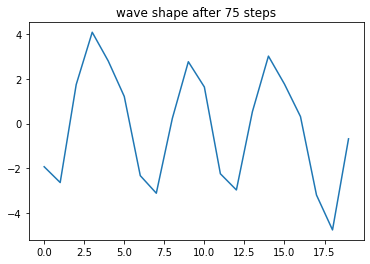

76it [03:50,  3.23s/it]

Training Step: 76
generator loss:0.31345485085644503
-----------------------
total discriminator loss:0.9498566480271771
average true return:0.650975312516516
-----------------------


77it [03:53,  3.16s/it]

Training Step: 77
generator loss:0.2945927157656386
-----------------------
total discriminator loss:0.5825662565209895
average true return:0.662018218268791
-----------------------


78it [03:56,  3.11s/it]

Training Step: 78
generator loss:0.2655320222733122
-----------------------
total discriminator loss:1.0433844361375648
average true return:0.6674343111970318
-----------------------


79it [03:59,  3.06s/it]

Training Step: 79
generator loss:0.2550193674198581
-----------------------
total discriminator loss:1.0840855061707726
average true return:0.6748705914819361
-----------------------


80it [04:02,  3.03s/it]

Training Step: 80
generator loss:0.2512201840293395
-----------------------
total discriminator loss:1.049711750011995
average true return:0.676363080747886
-----------------------


81it [04:05,  3.01s/it]

Training Step: 81
generator loss:0.2549786863967497
-----------------------
total discriminator loss:1.0705554389358864
average true return:0.6672722674600304
-----------------------


82it [04:08,  3.00s/it]

Training Step: 82
generator loss:0.26953720179381474
-----------------------
total discriminator loss:0.991141702211276
average true return:0.6635659533426224
-----------------------


83it [04:10,  2.99s/it]

Training Step: 83
generator loss:0.27565308714503867
-----------------------
total discriminator loss:1.0046199075263176
average true return:0.6576187005540792
-----------------------


84it [04:13,  2.98s/it]

Training Step: 84
generator loss:0.3011747081741507
-----------------------
total discriminator loss:0.9826567717973834
average true return:0.6434545494989381
-----------------------


85it [04:17,  3.01s/it]

Training Step: 85
generator loss:0.3126252316052992
-----------------------
total discriminator loss:0.5993579664005918
average true return:0.6568944844790287
-----------------------


86it [04:20,  3.00s/it]

Training Step: 86
generator loss:0.324307417507126
-----------------------
total discriminator loss:0.9856160508997318
average true return:0.6466326596131879
-----------------------


87it [04:22,  2.97s/it]

Training Step: 87
generator loss:0.34508070048763956
-----------------------
total discriminator loss:0.9657580194243542
average true return:0.6353399352202956
-----------------------


88it [04:25,  2.96s/it]

Training Step: 88
generator loss:0.34470961385294185
-----------------------
total discriminator loss:0.9579942610697902
average true return:0.6323988661911015
-----------------------


89it [04:28,  2.96s/it]

Training Step: 89
generator loss:0.34840537714013986
-----------------------
total discriminator loss:0.9501524864327525
average true return:0.6191137562447544
-----------------------


90it [04:31,  2.96s/it]

Training Step: 90
generator loss:0.34960899798453254
-----------------------
total discriminator loss:0.9384138961287565
average true return:0.6240981742962635
-----------------------


91it [04:34,  3.04s/it]

Training Step: 91
generator loss:0.3668713030416211
-----------------------
total discriminator loss:0.9579350633249222
average true return:0.6334965648820418
-----------------------


92it [04:37,  3.03s/it]

Training Step: 92
generator loss:0.3568256798311771
-----------------------
total discriminator loss:0.9572678214998449
average true return:0.6341605368978883
-----------------------


93it [04:41,  3.03s/it]

Training Step: 93
generator loss:0.35101009301474206
-----------------------
total discriminator loss:0.9652684041592329
average true return:0.6248444238388673
-----------------------


94it [04:44,  3.02s/it]

Training Step: 94
generator loss:0.37402996427214164
-----------------------
total discriminator loss:0.9248603597392477
average true return:0.6312156925588217
-----------------------


95it [04:46,  3.00s/it]

Training Step: 95
generator loss:0.360792042657051
-----------------------
total discriminator loss:0.9161102984123317
average true return:0.6323575182199053
-----------------------


96it [04:49,  3.00s/it]

Training Step: 96
generator loss:0.37601394905606994
-----------------------
total discriminator loss:0.8761598643083903
average true return:0.6395180060516616
-----------------------


97it [04:52,  3.00s/it]

Training Step: 97
generator loss:0.3547947371420301
-----------------------
total discriminator loss:0.6319309046572719
average true return:0.6333459763967348
-----------------------


98it [04:56,  3.01s/it]

Training Step: 98
generator loss:0.37327632916058867
-----------------------
total discriminator loss:0.8616230710977015
average true return:0.6360236928038159
-----------------------


99it [04:59,  3.01s/it]

Training Step: 99
generator loss:0.37431549950929177
-----------------------
total discriminator loss:0.8579892687654923
average true return:0.6388628228578959
-----------------------


100it [05:02,  3.01s/it]

Training Step: 100
generator loss:0.37566165497548965
-----------------------
total discriminator loss:0.8577734742717215
average true return:0.631098162168041
-----------------------
tf.Tensor([[3 0 1 1 1 2 2 2 2 3 3 3 3 0 1 1 2 2 3 3]], shape=(1, 20), dtype=int64)


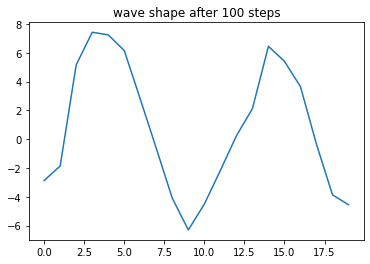

101it [05:05,  3.27s/it]

Training Step: 101
generator loss:0.3847960194316106
-----------------------
total discriminator loss:0.8162782907273956
average true return:0.6263353695253431
-----------------------


102it [05:08,  3.17s/it]

Training Step: 102
generator loss:0.40848701368650653
-----------------------
total discriminator loss:0.8056549036491245
average true return:0.6244972992241573
-----------------------


103it [05:11,  3.12s/it]

Training Step: 103
generator loss:0.4410853435844981
-----------------------
total discriminator loss:0.7831146293167706
average true return:0.6155256968740743
-----------------------


104it [05:14,  3.08s/it]

Training Step: 104
generator loss:0.47317811039978797
-----------------------
total discriminator loss:0.789966685418648
average true return:0.6194757199772318
-----------------------


105it [05:17,  3.04s/it]

Training Step: 105
generator loss:0.48911148070991606
-----------------------
total discriminator loss:0.7749703104441664
average true return:0.6160073486382154
-----------------------


106it [05:20,  3.03s/it]

Training Step: 106
generator loss:0.48303134301165573
-----------------------
total discriminator loss:0.763064495533724
average true return:0.6236055119382102
-----------------------


107it [05:23,  3.01s/it]

Training Step: 107
generator loss:0.4792338801258916
-----------------------
total discriminator loss:0.7488397529216001
average true return:0.6299708581806736
-----------------------


108it [05:26,  2.97s/it]

Training Step: 108
generator loss:0.4754947589690605
-----------------------
total discriminator loss:0.7392070457178659
average true return:0.640224535407032
-----------------------


109it [05:29,  2.98s/it]

Training Step: 109
generator loss:0.4923365732780429
-----------------------
total discriminator loss:0.7202488992840951
average true return:0.6416690530087032
-----------------------


110it [05:32,  2.98s/it]

Training Step: 110
generator loss:0.48039510174186906
-----------------------
total discriminator loss:0.7709141995089719
average true return:0.6536590809807837
-----------------------


111it [05:35,  3.00s/it]

Training Step: 111
generator loss:0.4751048542493831
-----------------------
total discriminator loss:0.7240044746336329
average true return:0.6544538592174709
-----------------------


112it [05:38,  3.06s/it]

Training Step: 112
generator loss:0.4765210491181001
-----------------------
total discriminator loss:0.6990780812525592
average true return:0.6460209162367035
-----------------------


113it [05:41,  3.04s/it]

Training Step: 113
generator loss:0.48666779606728083
-----------------------
total discriminator loss:0.6999736225319038
average true return:0.6473087668041397
-----------------------


114it [05:44,  3.02s/it]

Training Step: 114
generator loss:0.4984948429806912
-----------------------
total discriminator loss:0.7044218619299615
average true return:0.647370283589605
-----------------------


115it [05:47,  3.01s/it]

Training Step: 115
generator loss:0.5140963825136771
-----------------------
total discriminator loss:0.6769339569374511
average true return:0.6407664466677786
-----------------------


116it [05:50,  3.00s/it]

Training Step: 116
generator loss:0.5119699096887025
-----------------------
total discriminator loss:0.6822417881208658
average true return:0.6479757273499362
-----------------------


117it [05:53,  3.00s/it]

Training Step: 117
generator loss:0.528771139958628
-----------------------
total discriminator loss:0.6793177948544926
average true return:0.6434422596527891
-----------------------


118it [05:56,  3.00s/it]

Training Step: 118
generator loss:0.520889156820137
-----------------------
total discriminator loss:0.6701238849303945
average true return:0.6426191281247672
-----------------------


119it [05:59,  2.99s/it]

Training Step: 119
generator loss:0.5303112662011485
-----------------------
total discriminator loss:0.6644024214785544
average true return:0.6408176071910539
-----------------------


120it [06:02,  2.98s/it]

Training Step: 120
generator loss:0.540198130152621
-----------------------
total discriminator loss:0.6585839329759432
average true return:0.6417076807826981
-----------------------


121it [06:05,  2.98s/it]

Training Step: 121
generator loss:0.5326144701763809
-----------------------
total discriminator loss:0.6807102758093436
average true return:0.6422533321175288
-----------------------


122it [06:08,  2.99s/it]

Training Step: 122
generator loss:0.5325925510218841
-----------------------
total discriminator loss:0.6726674384949104
average true return:0.6445765936861566
-----------------------


123it [06:11,  2.97s/it]

Training Step: 123
generator loss:0.5334809363132618
-----------------------
total discriminator loss:0.6803466796687562
average true return:0.6474373905926769
-----------------------


124it [06:14,  2.99s/it]

Training Step: 124
generator loss:0.5308301497392428
-----------------------
total discriminator loss:0.6616290746723241
average true return:0.6404117859187406
-----------------------


125it [06:17,  3.00s/it]

Training Step: 125
generator loss:0.5396531331898945
-----------------------
total discriminator loss:0.6710653306475173
average true return:0.6390142026812935
-----------------------
tf.Tensor([[1 0 1 1 2 2 2 3 3 0 1 1 1 1 2 2 3 3 0 1]], shape=(1, 20), dtype=int64)


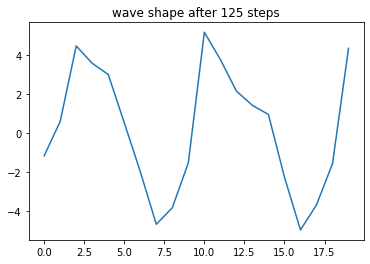

126it [06:21,  3.25s/it]

Training Step: 126
generator loss:0.5334779574660066
-----------------------
total discriminator loss:0.6829159995575502
average true return:0.6415179233429508
-----------------------


127it [06:24,  3.16s/it]

Training Step: 127
generator loss:0.5279970595231082
-----------------------
total discriminator loss:0.6801392182685122
average true return:0.6358665869184909
-----------------------


128it [06:27,  3.10s/it]

Training Step: 128
generator loss:0.5253888642420628
-----------------------
total discriminator loss:0.6996172767242751
average true return:0.6369460260284273
-----------------------


129it [06:30,  3.06s/it]

Training Step: 129
generator loss:0.5150723859113275
-----------------------
total discriminator loss:0.6926506070339737
average true return:0.6328648222211264
-----------------------


130it [06:33,  3.03s/it]

Training Step: 130
generator loss:0.5193916615086056
-----------------------
total discriminator loss:0.690029304394363
average true return:0.6320783600537712
-----------------------


131it [06:36,  3.01s/it]

Training Step: 131
generator loss:0.5211129479982862
-----------------------
total discriminator loss:0.7040589315610606
average true return:0.6260909018675905
-----------------------


132it [06:39,  2.99s/it]

Training Step: 132
generator loss:0.5097374139635213
-----------------------
total discriminator loss:0.7052751767618826
average true return:0.6272868950822537
-----------------------


133it [06:42,  2.97s/it]

Training Step: 133
generator loss:0.5191389664653201
-----------------------
total discriminator loss:0.7006928057744134
average true return:0.6181226067738602
-----------------------


134it [06:45,  3.05s/it]

Training Step: 134
generator loss:0.5250387708445361
-----------------------
total discriminator loss:0.6983026362323986
average true return:0.6080592222074852
-----------------------


135it [06:48,  3.05s/it]

Training Step: 135
generator loss:0.5475568250275435
-----------------------
total discriminator loss:0.6948557663037492
average true return:0.5979189284603618
-----------------------


136it [06:51,  3.02s/it]

Training Step: 136
generator loss:0.5616073164329314
-----------------------
total discriminator loss:0.6840819238879263
average true return:0.5840073427839141
-----------------------


137it [06:54,  2.99s/it]

Training Step: 137
generator loss:0.5819521366599968
-----------------------
total discriminator loss:0.6917064095720593
average true return:0.579367190954758
-----------------------


138it [06:57,  2.98s/it]

Training Step: 138
generator loss:0.6061615865619188
-----------------------
total discriminator loss:0.6835290759372908
average true return:0.5607483417818717
-----------------------


139it [07:00,  2.97s/it]

Training Step: 139
generator loss:0.6159574843621269
-----------------------
total discriminator loss:0.6845419203985028
average true return:0.5459243773550938
-----------------------


140it [07:03,  2.96s/it]

Training Step: 140
generator loss:0.6485858403166825
-----------------------
total discriminator loss:0.688294662351072
average true return:0.5307338506798541
-----------------------


141it [07:06,  2.97s/it]

Training Step: 141
generator loss:0.6708392510783128
-----------------------
total discriminator loss:0.6875641928687672
average true return:0.5206015345449108
-----------------------


142it [07:09,  2.96s/it]

Training Step: 142
generator loss:0.6870903807867244
-----------------------
total discriminator loss:0.6899144445421733
average true return:0.5097894404367195
-----------------------


143it [07:12,  2.96s/it]

Training Step: 143
generator loss:0.7070859283030209
-----------------------
total discriminator loss:0.68142910574068
average true return:0.5003116748544909
-----------------------


144it [07:14,  2.95s/it]

Training Step: 144
generator loss:0.7191228445830173
-----------------------
total discriminator loss:0.6869464493174284
average true return:0.49145967624716236
-----------------------


145it [07:17,  2.94s/it]

Training Step: 145
generator loss:0.7299790862492053
-----------------------
total discriminator loss:0.6796534445625066
average true return:0.48629981623666657
-----------------------


146it [07:20,  2.94s/it]

Training Step: 146
generator loss:0.7466716104293983
-----------------------
total discriminator loss:0.6766785448153396
average true return:0.48165870127529176
-----------------------


147it [07:23,  2.94s/it]

Training Step: 147
generator loss:0.73445473533568
-----------------------
total discriminator loss:0.6808931417240944
average true return:0.4827026276635533
-----------------------


148it [07:26,  2.93s/it]

Training Step: 148
generator loss:0.7325449753665166
-----------------------
total discriminator loss:0.6742277349310524
average true return:0.49959312005140727
-----------------------


149it [07:29,  2.93s/it]

Training Step: 149
generator loss:0.7336087246658665
-----------------------
total discriminator loss:0.6684358166522343
average true return:0.5076036875538459
-----------------------


150it [07:32,  2.93s/it]

Training Step: 150
generator loss:0.7100256143259795
-----------------------
total discriminator loss:0.6573930890316309
average true return:0.5186655286014832
-----------------------
tf.Tensor([[0 1 2 3 0 1 2 2 3 3 0 1 1 2 2 3 3 3 0 1]], shape=(1, 20), dtype=int64)


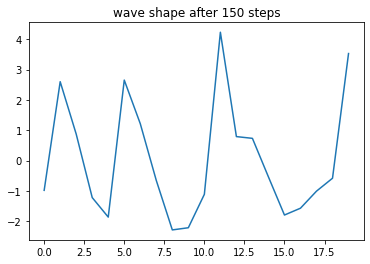

151it [07:36,  3.20s/it]

Training Step: 151
generator loss:0.7085566803147624
-----------------------
total discriminator loss:0.6666123015324716
average true return:0.5226835781536424
-----------------------


152it [07:39,  3.13s/it]

Training Step: 152
generator loss:0.7026391595892771
-----------------------
total discriminator loss:0.6540231821989834
average true return:0.5278324829106267
-----------------------


153it [07:42,  3.16s/it]

Training Step: 153
generator loss:0.6799712309482557
-----------------------
total discriminator loss:0.6528956071838494
average true return:0.5358013926699339
-----------------------


154it [07:45,  3.10s/it]

Training Step: 154
generator loss:0.679203041276867
-----------------------
total discriminator loss:0.6499948141779041
average true return:0.5332509581534677
-----------------------


155it [07:48,  3.06s/it]

Training Step: 155
generator loss:0.6683404271279768
-----------------------
total discriminator loss:0.6503892964320661
average true return:0.5352508126324363
-----------------------


156it [07:51,  3.03s/it]

Training Step: 156
generator loss:0.6651509047561769
-----------------------
total discriminator loss:0.6539404425205428
average true return:0.5414987748322297
-----------------------


157it [07:54,  3.00s/it]

Training Step: 157
generator loss:0.6605750806923493
-----------------------
total discriminator loss:0.6599845397754559
average true return:0.5308405270597334
-----------------------


158it [07:57,  3.00s/it]

Training Step: 158
generator loss:0.6709849166799797
-----------------------
total discriminator loss:0.6620267042908061
average true return:0.5325229591661329
-----------------------


159it [08:00,  2.99s/it]

Training Step: 159
generator loss:0.6604421602613131
-----------------------
total discriminator loss:0.6499249421664615
average true return:0.5370105037843704
-----------------------


160it [08:03,  2.97s/it]

Training Step: 160
generator loss:0.6462564982447486
-----------------------
total discriminator loss:0.6543669423142087
average true return:0.5507789036197475
-----------------------


161it [08:06,  2.97s/it]

Training Step: 161
generator loss:0.6170371592833743
-----------------------
total discriminator loss:0.6467005235101873
average true return:0.5597097633830663
-----------------------


162it [08:09,  2.96s/it]

Training Step: 162
generator loss:0.6092859709002849
-----------------------
total discriminator loss:0.6540421654990696
average true return:0.5660048364393835
-----------------------


163it [08:12,  2.95s/it]

Training Step: 163
generator loss:0.6032409965369998
-----------------------
total discriminator loss:0.6558157693119065
average true return:0.5744258680394816
-----------------------


164it [08:15,  2.98s/it]

Training Step: 164
generator loss:0.6065165646267108
-----------------------
total discriminator loss:0.6579123177264352
average true return:0.5689026419524994
-----------------------


165it [08:18,  2.98s/it]

Training Step: 165
generator loss:0.598495767294523
-----------------------
total discriminator loss:0.6521577747283493
average true return:0.5745981320820546
-----------------------


166it [08:21,  2.97s/it]

Training Step: 166
generator loss:0.6015751366616929
-----------------------
total discriminator loss:0.6542362682690397
average true return:0.5705474924440036
-----------------------


167it [08:24,  2.97s/it]

Training Step: 167
generator loss:0.6115584040721503
-----------------------
total discriminator loss:0.6442957541574202
average true return:0.5622820220829634
-----------------------


168it [08:27,  2.97s/it]

Training Step: 168
generator loss:0.6330567860424718
-----------------------
total discriminator loss:0.6468576425166375
average true return:0.5503044850223441
-----------------------


169it [08:29,  2.96s/it]

Training Step: 169
generator loss:0.6519907770536557
-----------------------
total discriminator loss:0.6437025455503091
average true return:0.5349383662432835
-----------------------


170it [08:32,  2.96s/it]

Training Step: 170
generator loss:0.6843685658569821
-----------------------
total discriminator loss:0.6386932404072687
average true return:0.5179289417974177
-----------------------


171it [08:35,  2.97s/it]

Training Step: 171
generator loss:0.7239973156033461
-----------------------
total discriminator loss:0.6442799378788178
average true return:0.49547932235657677
-----------------------


172it [08:38,  2.97s/it]

Training Step: 172
generator loss:0.7668335642099984
-----------------------
total discriminator loss:0.6523096139832685
average true return:0.4751454774321462
-----------------------


173it [08:42,  3.03s/it]

Training Step: 173
generator loss:0.8029650418541903
-----------------------
total discriminator loss:0.6662968505611877
average true return:0.4576105318291468
-----------------------


174it [08:45,  3.00s/it]

Training Step: 174
generator loss:0.8354908806902666
-----------------------
total discriminator loss:0.674210578227848
average true return:0.446059910317856
-----------------------


175it [08:48,  3.00s/it]

Training Step: 175
generator loss:0.8431841751152522
-----------------------
total discriminator loss:0.6837366503437177
average true return:0.44214992219129556
-----------------------
tf.Tensor([[3 0 1 2 3 3 0 1 2 2 3 0 1 2 3 3 0 1 2 3]], shape=(1, 20), dtype=int64)


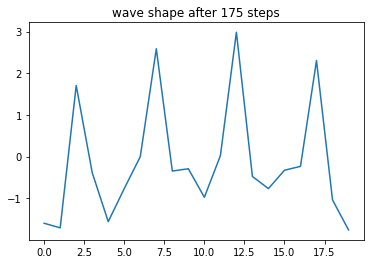

176it [08:51,  3.22s/it]

Training Step: 176
generator loss:0.8362831925766444
-----------------------
total discriminator loss:0.683548704904582
average true return:0.4492679387477574
-----------------------


177it [08:54,  3.14s/it]

Training Step: 177
generator loss:0.8094213726800488
-----------------------
total discriminator loss:0.6879565266672277
average true return:0.4565234678027309
-----------------------


178it [08:57,  3.09s/it]

Training Step: 178
generator loss:0.7784855058067945
-----------------------
total discriminator loss:0.6916986973890411
average true return:0.4721648764228807
-----------------------


179it [09:00,  3.04s/it]

Training Step: 179
generator loss:0.7355360482452126
-----------------------
total discriminator loss:0.6912891541676776
average true return:0.4938736607948166
-----------------------


180it [09:03,  3.02s/it]

Training Step: 180
generator loss:0.7048180748225257
-----------------------
total discriminator loss:0.682009526477234
average true return:0.5157993859992784
-----------------------


181it [09:06,  3.00s/it]

Training Step: 181
generator loss:0.6384197414601435
-----------------------
total discriminator loss:0.6719966828640737
average true return:0.5476921156825838
-----------------------


182it [09:09,  2.98s/it]

Training Step: 182
generator loss:0.580520811519283
-----------------------
total discriminator loss:0.6593634955955295
average true return:0.5784877518210492
-----------------------


183it [09:12,  2.97s/it]

Training Step: 183
generator loss:0.5193488077016299
-----------------------
total discriminator loss:0.6613252023244821
average true return:0.608877369769446
-----------------------


184it [09:15,  2.95s/it]

Training Step: 184
generator loss:0.49211196584339023
-----------------------
total discriminator loss:0.6856648496444002
average true return:0.600460893564226
-----------------------


185it [09:18,  2.93s/it]

Training Step: 185
generator loss:0.5121671776313756
-----------------------
total discriminator loss:0.7150196783136482
average true return:0.5902356831034943
-----------------------


186it [09:21,  2.94s/it]

Training Step: 186
generator loss:0.5283250229908334
-----------------------
total discriminator loss:0.6941545483765315
average true return:0.5833027225873153
-----------------------


187it [09:24,  2.95s/it]

Training Step: 187
generator loss:0.5377727618406811
-----------------------
total discriminator loss:0.65947237945486
average true return:0.5729536785292878
-----------------------


188it [09:26,  2.93s/it]

Training Step: 188
generator loss:0.5801086145184438
-----------------------
total discriminator loss:0.6206584809978299
average true return:0.5510983329827239
-----------------------


189it [09:29,  2.92s/it]

Training Step: 189
generator loss:0.6273611164959039
-----------------------
total discriminator loss:0.6023438838659232
average true return:0.5219995294857238
-----------------------


190it [09:32,  2.93s/it]

Training Step: 190
generator loss:0.6811015679611718
-----------------------
total discriminator loss:0.596159240661823
average true return:0.504933275851241
-----------------------


191it [09:35,  2.93s/it]

Training Step: 191
generator loss:0.7079607792914682
-----------------------
total discriminator loss:0.6049618436681907
average true return:0.4925532136756544
-----------------------


192it [09:38,  3.02s/it]

Training Step: 192
generator loss:0.7282753489740142
-----------------------
total discriminator loss:0.6032470653909958
average true return:0.48435554589984386
-----------------------


193it [09:41,  2.98s/it]

Training Step: 193
generator loss:0.752936291268832
-----------------------
total discriminator loss:0.603395586920462
average true return:0.4768839780388231
-----------------------


194it [09:44,  2.95s/it]

Training Step: 194
generator loss:0.7563725164247718
-----------------------
total discriminator loss:0.5963533739896762
average true return:0.4729897248264545
-----------------------


195it [09:47,  2.95s/it]

Training Step: 195
generator loss:0.762052553395829
-----------------------
total discriminator loss:0.5985202606667595
average true return:0.47145155275906375
-----------------------


196it [09:50,  2.94s/it]

Training Step: 196
generator loss:0.773280883209525
-----------------------
total discriminator loss:0.5875299276661796
average true return:0.46793474005002256
-----------------------


197it [09:53,  2.93s/it]

Training Step: 197
generator loss:0.7788522403986047
-----------------------
total discriminator loss:0.9182713192773373
average true return:0.4702625412249802
-----------------------


198it [09:56,  2.92s/it]

Training Step: 198
generator loss:0.7856817082688183
-----------------------
total discriminator loss:0.5892850053099503
average true return:0.47100785573638204
-----------------------


199it [09:59,  2.93s/it]

Training Step: 199
generator loss:0.7702926612670822
-----------------------
total discriminator loss:0.5905060823399936
average true return:0.4692385554774925
-----------------------


200it [10:02,  2.92s/it]

Training Step: 200
generator loss:0.7874119870250067
-----------------------
total discriminator loss:0.5783146762276153
average true return:0.47113837639532374
-----------------------
tf.Tensor([[3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2]], shape=(1, 20), dtype=int64)


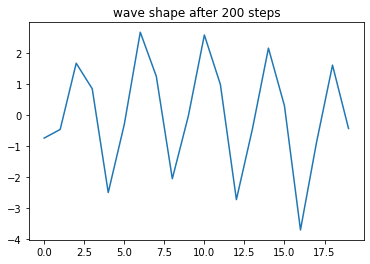

201it [10:06,  3.17s/it]

Training Step: 201
generator loss:0.7724658798185984
-----------------------
total discriminator loss:0.5886997217552677
average true return:0.47759958864524743
-----------------------


202it [10:08,  3.10s/it]

Training Step: 202
generator loss:0.7730033307032511
-----------------------
total discriminator loss:0.576431318288703
average true return:0.47434687027698835
-----------------------


203it [10:11,  3.04s/it]

Training Step: 203
generator loss:0.7677687073402581
-----------------------
total discriminator loss:0.5789636931783442
average true return:0.4776155557380688
-----------------------


204it [10:14,  2.99s/it]

Training Step: 204
generator loss:0.758253560643039
-----------------------
total discriminator loss:0.5786356030748415
average true return:0.480447033479238
-----------------------


205it [10:17,  3.00s/it]

Training Step: 205
generator loss:0.7500869089201254
-----------------------
total discriminator loss:0.5710101314957028
average true return:0.4853312580939724
-----------------------


206it [10:20,  2.97s/it]

Training Step: 206
generator loss:0.7492626855300484
-----------------------
total discriminator loss:0.5726251775365178
average true return:0.48657497162430785
-----------------------


207it [10:23,  2.94s/it]

Training Step: 207
generator loss:0.757942383901888
-----------------------
total discriminator loss:0.5594297005369249
average true return:0.4926603693803253
-----------------------


208it [10:26,  2.93s/it]

Training Step: 208
generator loss:0.7465308022930477
-----------------------
total discriminator loss:0.5647745820782011
average true return:0.493276312242771
-----------------------


209it [10:29,  2.89s/it]

Training Step: 209
generator loss:0.7376808038333571
-----------------------
total discriminator loss:1.0104668989342263
average true return:0.49711356536392615
-----------------------


210it [10:32,  2.92s/it]

Training Step: 210
generator loss:0.7327775711798962
-----------------------
total discriminator loss:0.570222249952725
average true return:0.5000639388789329
-----------------------


211it [10:35,  2.92s/it]

Training Step: 211
generator loss:0.7309516953508914
-----------------------
total discriminator loss:0.5756225130789239
average true return:0.5045192873119879
-----------------------


212it [10:38,  3.01s/it]

Training Step: 212
generator loss:0.728102764484215
-----------------------
total discriminator loss:1.0110602993588929
average true return:0.5056582482466079
-----------------------


213it [10:41,  2.98s/it]

Training Step: 213
generator loss:0.7175431743206048
-----------------------
total discriminator loss:0.5756530808880528
average true return:0.509348080121031
-----------------------


214it [10:44,  2.95s/it]

Training Step: 214
generator loss:0.7028341794104
-----------------------
total discriminator loss:0.559562738303385
average true return:0.5094820133901734
-----------------------


215it [10:47,  2.96s/it]

Training Step: 215
generator loss:0.7003079805403627
-----------------------
total discriminator loss:0.5721641456803769
average true return:0.5107383422413232
-----------------------


216it [10:50,  2.97s/it]

Training Step: 216
generator loss:0.7037097400192108
-----------------------
total discriminator loss:0.5669126761049987
average true return:0.5136656810394095
-----------------------


217it [10:53,  2.95s/it]

Training Step: 217
generator loss:0.6960244740572048
-----------------------
total discriminator loss:0.5697806942682283
average true return:0.5164578133201844
-----------------------


218it [10:55,  2.94s/it]

Training Step: 218
generator loss:0.6930578135030935
-----------------------
total discriminator loss:0.5645356233702369
average true return:0.5185103619861459
-----------------------


219it [10:58,  2.94s/it]

Training Step: 219
generator loss:0.6876927644779702
-----------------------
total discriminator loss:0.5702087642270564
average true return:0.5180740470839696
-----------------------


220it [11:01,  2.94s/it]

Training Step: 220
generator loss:0.693142614358826
-----------------------
total discriminator loss:0.5611705505384493
average true return:0.5206035585835831
-----------------------


221it [11:04,  2.93s/it]

Training Step: 221
generator loss:0.6919463020911325
-----------------------
total discriminator loss:0.569993590454708
average true return:0.5238977072437724
-----------------------


222it [11:07,  2.91s/it]

Training Step: 222
generator loss:0.6795753421956525
-----------------------
total discriminator loss:0.5583331613582632
average true return:0.5253810055606464
-----------------------


223it [11:10,  2.91s/it]

Training Step: 223
generator loss:0.6827396641635213
-----------------------
total discriminator loss:0.5408797258897354
average true return:0.5242774162670409
-----------------------


224it [11:13,  2.92s/it]

Training Step: 224
generator loss:0.6871238793200525
-----------------------
total discriminator loss:0.5624191862748074
average true return:0.525402895597433
-----------------------


225it [11:16,  2.92s/it]

Training Step: 225
generator loss:0.6881330726478256
-----------------------
total discriminator loss:0.5572633073886945
average true return:0.5269652545566201
-----------------------
tf.Tensor([[3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 0]], shape=(1, 20), dtype=int64)


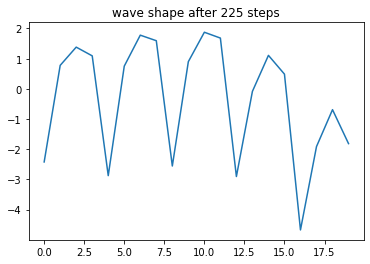

226it [11:20,  3.17s/it]

Training Step: 226
generator loss:0.6848948404869422
-----------------------
total discriminator loss:0.5533084258355682
average true return:0.5259126065184463
-----------------------


227it [11:23,  3.11s/it]

Training Step: 227
generator loss:0.6900719121488911
-----------------------
total discriminator loss:0.5454773940177517
average true return:0.527129470888142
-----------------------


228it [11:26,  3.06s/it]

Training Step: 228
generator loss:0.6837782154732865
-----------------------
total discriminator loss:0.5416394417586342
average true return:0.5284931870195002
-----------------------


229it [11:28,  3.02s/it]

Training Step: 229
generator loss:0.6861456200523361
-----------------------
total discriminator loss:0.562847278539399
average true return:0.5288147161521728
-----------------------


230it [11:32,  3.06s/it]

Training Step: 230
generator loss:0.684667610194097
-----------------------
total discriminator loss:1.094685570176194
average true return:0.530785938396418
-----------------------


231it [11:35,  3.02s/it]

Training Step: 231
generator loss:0.680532788134804
-----------------------
total discriminator loss:0.5333429603268665
average true return:0.5314908084360835
-----------------------


232it [11:38,  3.00s/it]

Training Step: 232
generator loss:0.672365181297391
-----------------------
total discriminator loss:0.5511660426342366
average true return:0.5352684020542477
-----------------------


233it [11:40,  2.97s/it]

Training Step: 233
generator loss:0.6699092883492681
-----------------------
total discriminator loss:0.5597742790416357
average true return:0.5356934299279421
-----------------------


234it [11:43,  2.97s/it]

Training Step: 234
generator loss:0.6637234988413956
-----------------------
total discriminator loss:0.5470582135834703
average true return:0.5377206088205035
-----------------------


235it [11:46,  2.96s/it]

Training Step: 235
generator loss:0.6652754534852922
-----------------------
total discriminator loss:0.5433590656659806
average true return:0.537932232714687
-----------------------


236it [11:49,  2.95s/it]

Training Step: 236
generator loss:0.6760777512813327
-----------------------
total discriminator loss:0.5343865054020629
average true return:0.5346134846237652
-----------------------


237it [11:52,  2.94s/it]

Training Step: 237
generator loss:0.678266565395832
-----------------------
total discriminator loss:0.5352326162620831
average true return:0.5342267583420643
-----------------------


238it [11:55,  2.93s/it]

Training Step: 238
generator loss:0.6770803713996365
-----------------------
total discriminator loss:0.5450832012990882
average true return:0.5314216472880409
-----------------------


239it [11:58,  2.93s/it]

Training Step: 239
generator loss:0.6868314383518914
-----------------------
total discriminator loss:0.537250786099678
average true return:0.5294047880295958
-----------------------


240it [12:01,  2.90s/it]

Training Step: 240
generator loss:0.6962474941427441
-----------------------
total discriminator loss:0.529226305286161
average true return:0.5267520092883298
-----------------------


241it [12:04,  2.90s/it]

Training Step: 241
generator loss:0.7089788053074183
-----------------------
total discriminator loss:0.5315585165501449
average true return:0.5220484341044155
-----------------------


242it [12:07,  2.90s/it]

Training Step: 242
generator loss:0.7284133628444814
-----------------------
total discriminator loss:0.5348090791988092
average true return:0.5140935769144414
-----------------------


243it [12:10,  2.90s/it]

Training Step: 243
generator loss:0.7467229453303386
-----------------------
total discriminator loss:0.5262527979834177
average true return:0.5071235508651021
-----------------------


244it [12:12,  2.90s/it]

Training Step: 244
generator loss:0.7671706845631296
-----------------------
total discriminator loss:0.5033821395384632
average true return:0.49850458281262855
-----------------------


245it [12:15,  2.95s/it]

Training Step: 245
generator loss:0.7920066312387937
-----------------------
total discriminator loss:0.5278318786590865
average true return:0.4921741426977847
-----------------------


246it [12:18,  2.94s/it]

Training Step: 246
generator loss:0.8067500090398549
-----------------------
total discriminator loss:0.5177225775044665
average true return:0.48616060854767096
-----------------------


247it [12:21,  2.93s/it]

Training Step: 247
generator loss:0.8269954308366254
-----------------------
total discriminator loss:0.5439058409608639
average true return:0.47804974930165367
-----------------------


248it [12:24,  2.92s/it]

Training Step: 248
generator loss:0.8505648632261564
-----------------------
total discriminator loss:0.5315433492302438
average true return:0.46999464173148
-----------------------


249it [12:27,  3.00s/it]

Training Step: 249
generator loss:0.8724597870648173
-----------------------
total discriminator loss:0.5399528545255831
average true return:0.4663475098325113
-----------------------


250it [12:30,  2.98s/it]

Training Step: 250
generator loss:0.876410437019941
-----------------------
total discriminator loss:0.5391256719847478
average true return:0.4631065109070207
-----------------------
tf.Tensor([[3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2]], shape=(1, 20), dtype=int64)


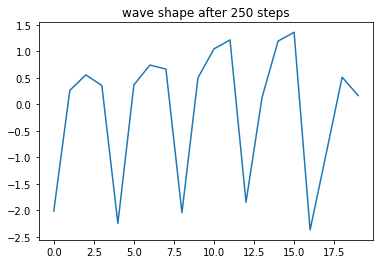

251it [12:34,  3.22s/it]

Training Step: 251
generator loss:0.8804706783650731
-----------------------
total discriminator loss:0.5365665310543013
average true return:0.4597590221163882
-----------------------


252it [12:37,  3.14s/it]

Training Step: 252
generator loss:0.8863192459042909
-----------------------
total discriminator loss:0.5444730028037317
average true return:0.4597313106918277
-----------------------


253it [12:40,  3.07s/it]

Training Step: 253
generator loss:0.8819272073015687
-----------------------
total discriminator loss:0.5331329630610541
average true return:0.459862708282026
-----------------------


254it [12:43,  3.02s/it]

Training Step: 254
generator loss:0.8841578089662817
-----------------------
total discriminator loss:0.5360275413177765
average true return:0.4612252517546397
-----------------------


255it [12:46,  3.00s/it]

Training Step: 255
generator loss:0.8770009739297753
-----------------------
total discriminator loss:0.5486749531625221
average true return:0.46348240683706965
-----------------------


256it [12:49,  3.01s/it]

Training Step: 256
generator loss:0.8763631232751009
-----------------------
total discriminator loss:0.546255527380805
average true return:0.46431267989483216
-----------------------


257it [12:52,  2.98s/it]

Training Step: 257
generator loss:0.8699101743365475
-----------------------
total discriminator loss:0.5441790149992717
average true return:0.46726958652768713
-----------------------


258it [12:55,  2.97s/it]

Training Step: 258
generator loss:0.8596239408975164
-----------------------
total discriminator loss:0.5316804213479426
average true return:0.46982564352673084
-----------------------


259it [12:58,  2.96s/it]

Training Step: 259
generator loss:0.8515721391668928
-----------------------
total discriminator loss:0.5449960112793747
average true return:0.47369239130331836
-----------------------


260it [13:01,  2.95s/it]

Training Step: 260
generator loss:0.8429472248906915
-----------------------
total discriminator loss:0.5413442179382895
average true return:0.4768633599938652
-----------------------


261it [13:04,  2.95s/it]

Training Step: 261
generator loss:0.8363790405942111
-----------------------
total discriminator loss:0.5300126415650204
average true return:0.48287597451495257
-----------------------


262it [13:06,  2.94s/it]

Training Step: 262
generator loss:0.8202201118892078
-----------------------
total discriminator loss:0.5329710485225145
average true return:0.48647491713783375
-----------------------


263it [13:09,  2.94s/it]

Training Step: 263
generator loss:0.8049815073598019
-----------------------
total discriminator loss:0.5238478073387762
average true return:0.4948751689189887
-----------------------


264it [13:12,  2.95s/it]

Training Step: 264
generator loss:0.7881436808703466
-----------------------
total discriminator loss:0.532829449478609
average true return:0.5036614905550145
-----------------------


265it [13:15,  2.93s/it]

Training Step: 265
generator loss:0.7556471286599763
-----------------------
total discriminator loss:0.5282502470139361
average true return:0.5190885640307943
-----------------------


266it [13:18,  2.91s/it]

Training Step: 266
generator loss:0.7231144571987167
-----------------------
total discriminator loss:0.50352643799837
average true return:0.5405629027782166
-----------------------


267it [13:21,  2.92s/it]

Training Step: 267
generator loss:0.6771680397836508
-----------------------
total discriminator loss:0.5272584847835935
average true return:0.556630960642015
-----------------------


268it [13:24,  2.99s/it]

Training Step: 268
generator loss:0.6421828841237558
-----------------------
total discriminator loss:0.5425500902235686
average true return:0.5685380249862126
-----------------------


269it [13:27,  2.98s/it]

Training Step: 269
generator loss:0.6334109401767836
-----------------------
total discriminator loss:0.5405452317428501
average true return:0.5707015776191677
-----------------------


270it [13:30,  2.96s/it]

Training Step: 270
generator loss:0.6217472819607726
-----------------------
total discriminator loss:0.5442397487770069
average true return:0.5690651482832889
-----------------------


271it [13:33,  2.94s/it]

Training Step: 271
generator loss:0.640125871408814
-----------------------
total discriminator loss:0.5402013784926218
average true return:0.5632591925792874
-----------------------


272it [13:36,  2.93s/it]

Training Step: 272
generator loss:0.6511114898902309
-----------------------
total discriminator loss:0.5639981901487588
average true return:0.5596477838251162
-----------------------


273it [13:39,  2.94s/it]

Training Step: 273
generator loss:0.668126589727245
-----------------------
total discriminator loss:0.5291519750419251
average true return:0.5560152641118354
-----------------------


274it [13:42,  2.92s/it]

Training Step: 274
generator loss:0.671948298066749
-----------------------
total discriminator loss:0.5350753492104023
average true return:0.5541388899107065
-----------------------


275it [13:45,  2.93s/it]

Training Step: 275
generator loss:0.6677568584771836
-----------------------
total discriminator loss:0.5594842419452869
average true return:0.5557475992101072
-----------------------
tf.Tensor([[2 3 0 1 2 0 1 2 0 0 2 3 0 1 2 3 0 1 2 3]], shape=(1, 20), dtype=int64)


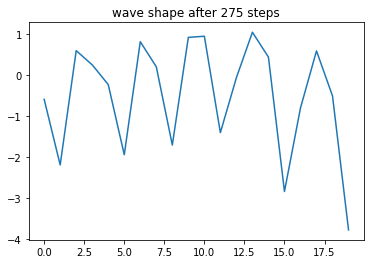

276it [13:48,  3.20s/it]

Training Step: 276
generator loss:0.6665621966767028
-----------------------
total discriminator loss:0.5332291181520863
average true return:0.5515341044927995
-----------------------


277it [13:51,  3.12s/it]

Training Step: 277
generator loss:0.6808417310408827
-----------------------
total discriminator loss:0.5318536201110422
average true return:0.5444088241874555
-----------------------


278it [13:54,  3.07s/it]

Training Step: 278
generator loss:0.700160244559157
-----------------------
total discriminator loss:0.5353136118229456
average true return:0.5355578184599881
-----------------------


279it [13:57,  3.03s/it]

Training Step: 279
generator loss:0.7270921090975352
-----------------------
total discriminator loss:0.503097325425055
average true return:0.5238834019113621
-----------------------


280it [14:00,  3.00s/it]

Training Step: 280
generator loss:0.7674161548328423
-----------------------
total discriminator loss:0.516939161500478
average true return:0.5061203105999533
-----------------------


281it [14:03,  2.96s/it]

Training Step: 281
generator loss:0.8173512354612871
-----------------------
total discriminator loss:0.49764635659401196
average true return:0.48961135532506117
-----------------------


282it [14:06,  2.95s/it]

Training Step: 282
generator loss:0.8688148732960796
-----------------------
total discriminator loss:0.49879486241511906
average true return:0.47416141148378443
-----------------------


283it [14:09,  2.94s/it]

Training Step: 283
generator loss:0.9135712808220482
-----------------------
total discriminator loss:0.5282602530368581
average true return:0.4602502966511035
-----------------------


284it [14:12,  2.94s/it]

Training Step: 284
generator loss:0.9433047989217532
-----------------------
total discriminator loss:0.5441760237154551
average true return:0.45077076763857765
-----------------------


285it [14:15,  2.94s/it]

Training Step: 285
generator loss:0.9644112721605489
-----------------------
total discriminator loss:0.5424490340885725
average true return:0.44756355266958403
-----------------------


286it [14:18,  3.00s/it]

Training Step: 286
generator loss:0.9611074618039059
-----------------------
total discriminator loss:0.5450487906709116
average true return:0.4490595211336885
-----------------------


287it [14:21,  2.98s/it]

Training Step: 287
generator loss:0.9528850090097646
-----------------------
total discriminator loss:0.5261844590045421
average true return:0.45199511625635536
-----------------------


288it [14:24,  3.03s/it]

Training Step: 288
generator loss:0.936328766846656
-----------------------
total discriminator loss:0.5352342131038837
average true return:0.4560949494369392
-----------------------


289it [14:27,  3.01s/it]

Training Step: 289
generator loss:0.9177999796703646
-----------------------
total discriminator loss:0.5582300945646679
average true return:0.46196677905898953
-----------------------


290it [14:30,  2.99s/it]

Training Step: 290
generator loss:0.898142416205947
-----------------------
total discriminator loss:0.5429208112219805
average true return:0.46938651894781785
-----------------------


291it [14:33,  2.96s/it]

Training Step: 291
generator loss:0.8700370968349191
-----------------------
total discriminator loss:0.5245910330694808
average true return:0.47813344462614576
-----------------------


292it [14:36,  2.96s/it]

Training Step: 292
generator loss:0.8441809033879297
-----------------------
total discriminator loss:0.539464127635033
average true return:0.48802296299520276
-----------------------


293it [14:39,  2.94s/it]

Training Step: 293
generator loss:0.8127092207884525
-----------------------
total discriminator loss:0.5462285752520972
average true return:0.4983641176066008
-----------------------


294it [14:42,  2.95s/it]

Training Step: 294
generator loss:0.7944874618904464
-----------------------
total discriminator loss:0.5449880714731131
average true return:0.5045008072229997
-----------------------


295it [14:45,  2.94s/it]

Training Step: 295
generator loss:0.7756525739632862
-----------------------
total discriminator loss:0.5629198110280929
average true return:0.5102119651991062
-----------------------


296it [14:48,  2.97s/it]

Training Step: 296
generator loss:0.7692932215223212
-----------------------
total discriminator loss:0.5657198859975479
average true return:0.5143746453571534
-----------------------


297it [14:51,  2.97s/it]

Training Step: 297
generator loss:0.7570985764171713
-----------------------
total discriminator loss:0.545990348991485
average true return:0.51616793899147
-----------------------


298it [14:54,  2.96s/it]

Training Step: 298
generator loss:0.7610571026186472
-----------------------
total discriminator loss:0.5403601248843191
average true return:0.5117715600582631
-----------------------


299it [14:56,  2.95s/it]

Training Step: 299
generator loss:0.7734310703106967
-----------------------
total discriminator loss:0.5353129745877403
average true return:0.5070225795948304
-----------------------


300it [14:59,  2.95s/it]

Training Step: 300
generator loss:0.7855563466667916
-----------------------
total discriminator loss:0.5450744142501736
average true return:0.5054388933698253
-----------------------
tf.Tensor([[0 2 0 1 2 0 1 2 0 0 1 2 3 0 1 2 3 0 1 1]], shape=(1, 20), dtype=int64)


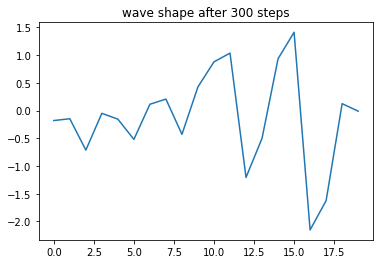

301it [15:03,  3.19s/it]

Training Step: 301
generator loss:0.7840837085547617
-----------------------
total discriminator loss:0.5401727312880513
average true return:0.5081535990404066
-----------------------


302it [15:06,  3.13s/it]

Training Step: 302
generator loss:0.7761320897965027
-----------------------
total discriminator loss:0.5284005515520229
average true return:0.5111782516420569
-----------------------


303it [15:09,  3.09s/it]

Training Step: 303
generator loss:0.7679253718033554
-----------------------
total discriminator loss:0.5341004151862117
average true return:0.513451269004043
-----------------------


304it [15:12,  3.02s/it]

Training Step: 304
generator loss:0.7675565713441662
-----------------------
total discriminator loss:0.5138354415837254
average true return:0.513547626169543
-----------------------


305it [15:15,  2.98s/it]

Training Step: 305
generator loss:0.7749785907300485
-----------------------
total discriminator loss:0.5410316656273852
average true return:0.5121737547806982
-----------------------


306it [15:18,  2.93s/it]

Training Step: 306
generator loss:0.7805968645345676
-----------------------
total discriminator loss:0.5067946938685777
average true return:0.510393472240169
-----------------------


307it [15:21,  2.93s/it]

Training Step: 307
generator loss:0.7864065040124453
-----------------------
total discriminator loss:0.5496685599421545
average true return:0.5109293435763174
-----------------------


308it [15:24,  2.93s/it]

Training Step: 308
generator loss:0.7818401049221373
-----------------------
total discriminator loss:0.5269049521579582
average true return:0.5133889807586162
-----------------------


309it [15:27,  3.01s/it]

Training Step: 309
generator loss:0.773605211151356
-----------------------
total discriminator loss:0.5325924422081617
average true return:0.5167581624438873
-----------------------


310it [15:30,  2.97s/it]

Training Step: 310
generator loss:0.766488571759364
-----------------------
total discriminator loss:0.5372221657228894
average true return:0.5195397413883257
-----------------------


311it [15:33,  2.96s/it]

Training Step: 311
generator loss:0.7656114176681589
-----------------------
total discriminator loss:0.5127601642086906
average true return:0.5184991200794522
-----------------------


312it [15:36,  2.95s/it]

Training Step: 312
generator loss:0.7743281156843952
-----------------------
total discriminator loss:0.5279624904725222
average true return:0.5167284184377495
-----------------------


313it [15:38,  2.95s/it]

Training Step: 313
generator loss:0.780868983543357
-----------------------
total discriminator loss:0.5240857357247783
average true return:0.5163853339237034
-----------------------


314it [15:41,  2.94s/it]

Training Step: 314
generator loss:0.7825278113501587
-----------------------
total discriminator loss:0.5246499310100976
average true return:0.5162923089261076
-----------------------


315it [15:44,  2.94s/it]

Training Step: 315
generator loss:0.7779380681504856
-----------------------
total discriminator loss:1.258572731875399
average true return:0.5153920331912383
-----------------------


316it [15:47,  2.94s/it]

Training Step: 316
generator loss:0.7737758083815347
-----------------------
total discriminator loss:0.5072226925141069
average true return:0.5162340812081907
-----------------------


317it [15:50,  2.93s/it]

Training Step: 317
generator loss:0.7775969715151853
-----------------------
total discriminator loss:0.5187666426350629
average true return:0.512559619145066
-----------------------


318it [15:53,  2.96s/it]

Training Step: 318
generator loss:0.7909972689360271
-----------------------
total discriminator loss:0.5252150258739319
average true return:0.5090846569630387
-----------------------


319it [15:56,  2.96s/it]

Training Step: 319
generator loss:0.8006796516710604
-----------------------
total discriminator loss:0.5161886071905892
average true return:0.5078879137886474
-----------------------


320it [15:59,  2.95s/it]

Training Step: 320
generator loss:0.8002352090452886
-----------------------
total discriminator loss:0.5302477986566219
average true return:0.5091106336853779
-----------------------


321it [16:02,  2.92s/it]

Training Step: 321
generator loss:0.7932640424264525
-----------------------
total discriminator loss:0.5206130740323449
average true return:0.5129393670029221
-----------------------


322it [16:05,  2.93s/it]

Training Step: 322
generator loss:0.7797160647945016
-----------------------
total discriminator loss:0.5166420061685366
average true return:0.5174061294606251
-----------------------


323it [16:08,  2.94s/it]

Training Step: 323
generator loss:0.7682811074091921
-----------------------
total discriminator loss:0.5230701624743971
average true return:0.5204553254122188
-----------------------


324it [16:11,  2.93s/it]

Training Step: 324
generator loss:0.7645790941826407
-----------------------
total discriminator loss:0.5142940173838817
average true return:0.5212908170138271
-----------------------


325it [16:14,  2.94s/it]

Training Step: 325
generator loss:0.768161510316101
-----------------------
total discriminator loss:0.5234970078781793
average true return:0.5197893241732537
-----------------------
tf.Tensor([[3 0 2 0 0 2 0 0 0 0 0 3 0 0 1 3 0 1 1 3]], shape=(1, 20), dtype=int64)


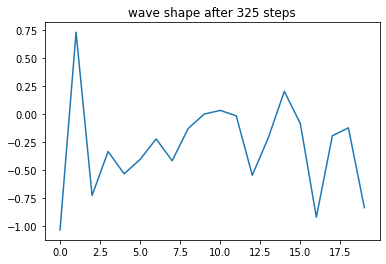

326it [16:18,  3.25s/it]

Training Step: 326
generator loss:0.7710399933312467
-----------------------
total discriminator loss:0.5185720276535604
average true return:0.5194072987601821
-----------------------


327it [16:21,  3.15s/it]

Training Step: 327
generator loss:0.7721747612703288
-----------------------
total discriminator loss:0.5147987940063286
average true return:0.5180284164715754
-----------------------


328it [16:23,  3.08s/it]

Training Step: 328
generator loss:0.7755153270021906
-----------------------
total discriminator loss:0.5075820794316852
average true return:0.5166907063594777
-----------------------


329it [16:26,  3.04s/it]

Training Step: 329
generator loss:0.7788420518416266
-----------------------
total discriminator loss:0.4985459537191984
average true return:0.5154736119808137
-----------------------


330it [16:30,  3.07s/it]

Training Step: 330
generator loss:0.7814226017979771
-----------------------
total discriminator loss:0.5231712728436222
average true return:0.5142375492292994
-----------------------


331it [16:33,  3.02s/it]

Training Step: 331
generator loss:0.788590470796509
-----------------------
total discriminator loss:0.4956656638053434
average true return:0.513351049642137
-----------------------


332it [16:35,  2.99s/it]

Training Step: 332
generator loss:0.7852321580949086
-----------------------
total discriminator loss:0.5194067455170973
average true return:0.5130203241577393
-----------------------


333it [16:38,  2.97s/it]

Training Step: 333
generator loss:0.7889275296363949
-----------------------
total discriminator loss:0.5194019198713966
average true return:0.5145001303853438
-----------------------


334it [16:41,  2.96s/it]

Training Step: 334
generator loss:0.7771944493231613
-----------------------
total discriminator loss:0.5222175077214162
average true return:0.5180533048734339
-----------------------


335it [16:44,  2.94s/it]

Training Step: 335
generator loss:0.764953061080586
-----------------------
total discriminator loss:0.5024101048374794
average true return:0.5166138171709488
-----------------------


336it [16:47,  2.93s/it]

Training Step: 336
generator loss:0.7728124662036742
-----------------------
total discriminator loss:0.5321454268620978
average true return:0.5175822382525123
-----------------------


337it [16:50,  2.92s/it]

Training Step: 337
generator loss:0.7701082012601236
-----------------------
total discriminator loss:0.5394902806456316
average true return:0.5178299395686861
-----------------------


338it [16:53,  2.92s/it]

Training Step: 338
generator loss:0.7657801537350455
-----------------------
total discriminator loss:0.5332757208446776
average true return:0.5179326778261972
-----------------------


339it [16:56,  2.92s/it]

Training Step: 339
generator loss:0.7613639546871821
-----------------------
total discriminator loss:0.5315154501287029
average true return:0.5182874306683054
-----------------------


340it [16:59,  2.93s/it]

Training Step: 340
generator loss:0.7776140886856168
-----------------------
total discriminator loss:0.5282254360677394
average true return:0.5130153120373615
-----------------------


341it [17:02,  2.94s/it]

Training Step: 341
generator loss:0.7856440699221833
-----------------------
total discriminator loss:0.5489630428833332
average true return:0.5128720292062741
-----------------------


342it [17:05,  2.93s/it]

Training Step: 342
generator loss:0.7831791932758541
-----------------------
total discriminator loss:0.5373423730627689
average true return:0.511468150063985
-----------------------


343it [17:08,  2.92s/it]

Training Step: 343
generator loss:0.7968239316534708
-----------------------
total discriminator loss:0.5289778955439559
average true return:0.5065263441128023
-----------------------


344it [17:11,  2.94s/it]

Training Step: 344
generator loss:0.8115360703958049
-----------------------
total discriminator loss:0.5207334434499071
average true return:0.5019662246508834
-----------------------


345it [17:13,  2.94s/it]

Training Step: 345
generator loss:0.8272469540562948
-----------------------
total discriminator loss:1.244994463493019
average true return:0.4969778990965975
-----------------------


346it [17:16,  2.94s/it]

Training Step: 346
generator loss:0.8235479888847326
-----------------------
total discriminator loss:0.5319896198399436
average true return:0.501442996383547
-----------------------


347it [17:19,  2.93s/it]

Training Step: 347
generator loss:0.810936518292746
-----------------------
total discriminator loss:0.5350583685431556
average true return:0.5037347167157917
-----------------------


348it [17:22,  2.93s/it]

Training Step: 348
generator loss:0.8031564975263221
-----------------------
total discriminator loss:0.5350068950738263
average true return:0.5049854869882731
-----------------------


349it [17:25,  2.94s/it]

Training Step: 349
generator loss:0.8003878416392458
-----------------------
total discriminator loss:0.5251439902500945
average true return:0.5048805100019467
-----------------------


350it [17:28,  3.02s/it]

Training Step: 350
generator loss:0.7963723932392159
-----------------------
total discriminator loss:0.5267894707213214
average true return:0.5051065835283535
-----------------------
tf.Tensor([[2 3 0 2 3 0 2 3 0 2 3 0 2 3 0 2 3 0 2 2]], shape=(1, 20), dtype=int64)


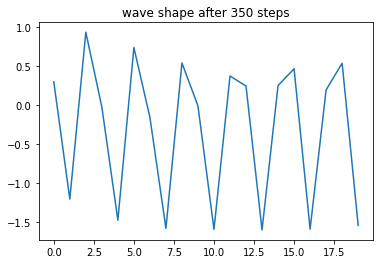

351it [17:32,  3.24s/it]

Training Step: 351
generator loss:0.7959098748884321
-----------------------
total discriminator loss:0.5270773194591698
average true return:0.5045367579944695
-----------------------


352it [17:35,  3.14s/it]

Training Step: 352
generator loss:0.7948788970785956
-----------------------
total discriminator loss:0.5256638059154581
average true return:0.5054225008652865
-----------------------


353it [17:38,  3.07s/it]

Training Step: 353
generator loss:0.7942484877832829
-----------------------
total discriminator loss:0.5326151862023623
average true return:0.503671913278042
-----------------------


354it [17:41,  3.03s/it]

Training Step: 354
generator loss:0.7979625276989035
-----------------------
total discriminator loss:0.5316036087858126
average true return:0.5021069865480051
-----------------------


355it [17:44,  3.01s/it]

Training Step: 355
generator loss:0.8026470477046324
-----------------------
total discriminator loss:0.5269136981633022
average true return:0.5012824221067194
-----------------------


356it [17:47,  2.99s/it]

Training Step: 356
generator loss:0.8101681746780811
-----------------------
total discriminator loss:1.2040622317676026
average true return:0.4983075410104283
-----------------------


357it [17:50,  2.97s/it]

Training Step: 357
generator loss:0.8033648101283264
-----------------------
total discriminator loss:0.5328441880547194
average true return:0.5024834006116361
-----------------------


358it [17:53,  2.96s/it]

Training Step: 358
generator loss:0.7877040227161523
-----------------------
total discriminator loss:0.5167484610622495
average true return:0.5079799384917181
-----------------------


359it [17:56,  2.93s/it]

Training Step: 359
generator loss:0.7738614622419842
-----------------------
total discriminator loss:0.5343156965417322
average true return:0.5118049189548182
-----------------------


360it [17:58,  2.93s/it]

Training Step: 360
generator loss:0.7645043925360862
-----------------------
total discriminator loss:0.5212673848449854
average true return:0.5157838309911047
-----------------------


361it [18:01,  2.93s/it]

Training Step: 361
generator loss:0.7588854552356403
-----------------------
total discriminator loss:0.513455821130657
average true return:0.5171598861089615
-----------------------


362it [18:04,  2.92s/it]

Training Step: 362
generator loss:0.7577448912117944
-----------------------
total discriminator loss:0.5180848719422301
average true return:0.5183121755738375
-----------------------


363it [18:07,  2.92s/it]

Training Step: 363
generator loss:0.7601937753060007
-----------------------
total discriminator loss:0.5047893797822645
average true return:0.5158774037572484
-----------------------


364it [18:10,  2.89s/it]

Training Step: 364
generator loss:0.7715397971881119
-----------------------
total discriminator loss:0.5048434089102101
average true return:0.5121085431906264
-----------------------


365it [18:13,  2.90s/it]

Training Step: 365
generator loss:0.7964727117925081
-----------------------
total discriminator loss:0.508578953552748
average true return:0.5036662185027865
-----------------------


366it [18:16,  2.96s/it]

Training Step: 366
generator loss:0.8213989150096698
-----------------------
total discriminator loss:0.4818503763935257
average true return:0.4977625841831894
-----------------------


367it [18:19,  2.92s/it]

Training Step: 367
generator loss:0.8497178453891638
-----------------------
total discriminator loss:0.4805800702349493
average true return:0.4915438284143734
-----------------------


368it [18:22,  2.90s/it]

Training Step: 368
generator loss:0.8696841373939888
-----------------------
total discriminator loss:0.47043772704829145
average true return:0.48813792756163166
-----------------------


369it [18:25,  2.96s/it]

Training Step: 369
generator loss:0.8797961043210265
-----------------------
total discriminator loss:0.47456274816290445
average true return:0.4907303299345067
-----------------------


370it [18:28,  2.94s/it]

Training Step: 370
generator loss:0.8759846752168099
-----------------------
total discriminator loss:0.4799689960961501
average true return:0.49289497416750094
-----------------------


371it [18:31,  2.93s/it]

Training Step: 371
generator loss:0.8610773322860443
-----------------------
total discriminator loss:0.4695787538368522
average true return:0.5016335843824093
-----------------------


372it [18:34,  2.93s/it]

Training Step: 372
generator loss:0.829316352803569
-----------------------
total discriminator loss:0.49861467586310554
average true return:0.5185608537459998
-----------------------


373it [18:36,  2.93s/it]

Training Step: 373
generator loss:0.7608226371605191
-----------------------
total discriminator loss:0.4992979767739524
average true return:0.542525431285892
-----------------------


374it [18:39,  2.92s/it]

Training Step: 374
generator loss:0.6835286493879563
-----------------------
total discriminator loss:0.49531268890032265
average true return:0.5673986161838298
-----------------------


375it [18:42,  2.90s/it]

Training Step: 375
generator loss:0.6338604970167347
-----------------------
total discriminator loss:1.160161708202962
average true return:0.5901918232719252
-----------------------
tf.Tensor([[3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1]], shape=(1, 20), dtype=int64)


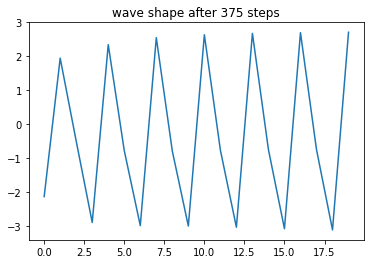

376it [18:46,  3.15s/it]

Training Step: 376
generator loss:0.5639345478653801
-----------------------
total discriminator loss:0.5075605513627132
average true return:0.6319650399249477
-----------------------


377it [18:49,  3.11s/it]

Training Step: 377
generator loss:0.4632592634477042
-----------------------
total discriminator loss:0.5681076319689395
average true return:0.7023731065440644
-----------------------


378it [18:52,  3.05s/it]

Training Step: 378
generator loss:0.34475118024173673
-----------------------
total discriminator loss:0.6573765377589189
average true return:0.7638365467541692
-----------------------


379it [18:55,  3.01s/it]

Training Step: 379
generator loss:0.23741489596128307
-----------------------
total discriminator loss:0.9578945460538584
average true return:0.8392749130993347
-----------------------


380it [18:58,  2.97s/it]

Training Step: 380
generator loss:0.16736497605969203
-----------------------
total discriminator loss:1.0042382498678473
average true return:0.8482213081010377
-----------------------


381it [19:01,  2.94s/it]

Training Step: 381
generator loss:0.18608364459326326
-----------------------
total discriminator loss:0.9279956321056042
average true return:0.8247185485393211
-----------------------


382it [19:03,  2.91s/it]

Training Step: 382
generator loss:0.23011041716735114
-----------------------
total discriminator loss:0.8442741962533042
average true return:0.7867318323886953
-----------------------


383it [19:06,  2.90s/it]

Training Step: 383
generator loss:0.2917758898920679
-----------------------
total discriminator loss:0.7710949252574644
average true return:0.7444970764470977
-----------------------


384it [19:09,  2.89s/it]

Training Step: 384
generator loss:0.3582773380692008
-----------------------
total discriminator loss:0.7334374269191146
average true return:0.7040641112862515
-----------------------


385it [19:12,  2.90s/it]

Training Step: 385
generator loss:0.43420719401192986
-----------------------
total discriminator loss:0.6824266638553135
average true return:0.6571750089293971
-----------------------


386it [19:15,  2.90s/it]

Training Step: 386
generator loss:0.5306265911887826
-----------------------
total discriminator loss:0.6114480191706997
average true return:0.5853956548676328
-----------------------


387it [19:18,  2.90s/it]

Training Step: 387
generator loss:0.7310315529629282
-----------------------
total discriminator loss:0.5083087767372273
average true return:0.43521404607678577
-----------------------


388it [19:21,  2.97s/it]

Training Step: 388
generator loss:1.28620813609199
-----------------------
total discriminator loss:0.49940284258034706
average true return:0.31520791727302555
-----------------------


389it [19:24,  2.94s/it]

Training Step: 389
generator loss:1.4370539592092533
-----------------------
total discriminator loss:0.5669836501786846
average true return:0.29538826179092836
-----------------------


390it [19:27,  2.93s/it]

Training Step: 390
generator loss:1.3163374250459867
-----------------------
total discriminator loss:0.594458808149587
average true return:0.32644339784889415
-----------------------


391it [19:30,  2.92s/it]

Training Step: 391
generator loss:1.2342246079241836
-----------------------
total discriminator loss:0.6172193911434909
average true return:0.3267123792564609
-----------------------


392it [19:33,  2.91s/it]

Training Step: 392
generator loss:1.2720864805321888
-----------------------
total discriminator loss:0.6401466923883716
average true return:0.3162194705489758
-----------------------


393it [19:35,  2.90s/it]

Training Step: 393
generator loss:1.2687479251935332
-----------------------
total discriminator loss:0.6209578008441083
average true return:0.3206309977189796
-----------------------


394it [19:38,  2.91s/it]

Training Step: 394
generator loss:1.2562141298089842
-----------------------
total discriminator loss:0.6351308124791782
average true return:0.3253074130350444
-----------------------


395it [19:41,  2.90s/it]

Training Step: 395
generator loss:1.2427195739027055
-----------------------
total discriminator loss:0.6305032762946429
average true return:0.3327076170790774
-----------------------


396it [19:44,  2.90s/it]

Training Step: 396
generator loss:1.2148503326739926
-----------------------
total discriminator loss:0.6118223484519628
average true return:0.34364645721115006
-----------------------


397it [19:47,  2.89s/it]

Training Step: 397
generator loss:1.1868650369904497
-----------------------
total discriminator loss:0.592829503916567
average true return:0.3553801606649776
-----------------------


398it [19:50,  2.90s/it]

Training Step: 398
generator loss:1.1482103938431596
-----------------------
total discriminator loss:0.5800379265194047
average true return:0.3694583091114958
-----------------------


399it [19:53,  2.90s/it]

Training Step: 399
generator loss:1.1008407980590893
-----------------------
total discriminator loss:0.567073376822247
average true return:0.38588681688832827
-----------------------


400it [19:56,  2.90s/it]

Training Step: 400
generator loss:1.047101638171546
-----------------------
total discriminator loss:0.5589066223966801
average true return:0.4048316654874995
-----------------------
tf.Tensor([[1 2 3 1 2 3 1 2 3 1 2 0 1 2 3 1 2 3 1 2]], shape=(1, 20), dtype=int64)


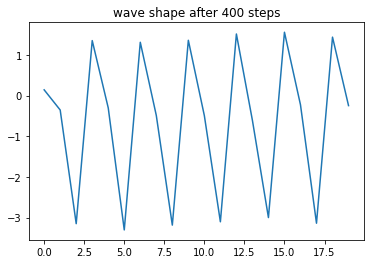

401it [19:59,  3.14s/it]

Training Step: 401
generator loss:0.9840783951024236
-----------------------
total discriminator loss:0.5494195654772658
average true return:0.4265474438201427
-----------------------


402it [20:02,  3.06s/it]

Training Step: 402
generator loss:0.9147875172722669
-----------------------
total discriminator loss:0.550976396647997
average true return:0.4514593090315476
-----------------------


403it [20:05,  3.01s/it]

Training Step: 403
generator loss:0.8461523686893845
-----------------------
total discriminator loss:0.5514689315445183
average true return:0.47343232890212794
-----------------------


404it [20:08,  2.98s/it]

Training Step: 404
generator loss:0.7807994769014397
-----------------------
total discriminator loss:0.56412182529985
average true return:0.4971172337248214
-----------------------


405it [20:11,  2.96s/it]

Training Step: 405
generator loss:0.7219870363798224
-----------------------
total discriminator loss:0.5799395117496042
average true return:0.5171183457298865
-----------------------


406it [20:14,  2.95s/it]

Training Step: 406
generator loss:0.673113845157002
-----------------------
total discriminator loss:0.592084255281051
average true return:0.5342406722227657
-----------------------


407it [20:17,  3.00s/it]

Training Step: 407
generator loss:0.637642578674773
-----------------------
total discriminator loss:0.6074301308650865
average true return:0.5455809459390335
-----------------------


408it [20:20,  2.97s/it]

Training Step: 408
generator loss:0.6150947207540269
-----------------------
total discriminator loss:0.6068673816969291
average true return:0.5542467145339742
-----------------------


409it [20:23,  3.05s/it]

Training Step: 409
generator loss:0.6048009055018406
-----------------------
total discriminator loss:0.6176869952180801
average true return:0.5592812735307958
-----------------------


410it [20:26,  3.04s/it]

Training Step: 410
generator loss:0.6017498975791052
-----------------------
total discriminator loss:0.6112514718432442
average true return:0.5542015636748417
-----------------------


411it [20:29,  3.04s/it]

Training Step: 411
generator loss:0.6023750164570727
-----------------------
total discriminator loss:0.6007237105370655
average true return:0.548682015357125
-----------------------


412it [20:32,  3.05s/it]

Training Step: 412
generator loss:0.6143177821005033
-----------------------
total discriminator loss:0.5839611269944375
average true return:0.5381258772090747
-----------------------


413it [20:35,  3.05s/it]

Training Step: 413
generator loss:0.6328171858412042
-----------------------
total discriminator loss:0.5736158575630237
average true return:0.5280804919364235
-----------------------


414it [20:38,  3.05s/it]

Training Step: 414
generator loss:0.662592718958809
-----------------------
total discriminator loss:0.5604366195854765
average true return:0.5160461919982579
-----------------------


415it [20:41,  3.04s/it]

Training Step: 415
generator loss:0.7021955181924153
-----------------------
total discriminator loss:0.5546621446980529
average true return:0.5057709488249506
-----------------------


416it [20:45,  3.05s/it]

Training Step: 416
generator loss:0.743640431872143
-----------------------
total discriminator loss:0.5488673052029853
average true return:0.4980415036071755
-----------------------


417it [20:48,  3.10s/it]

Training Step: 417
generator loss:0.7898596985690256
-----------------------
total discriminator loss:0.5562802216157215
average true return:0.4876548514184765
-----------------------


418it [20:51,  3.07s/it]

Training Step: 418
generator loss:0.8261289262120692
-----------------------
total discriminator loss:0.5510001671798668
average true return:0.4751541241762225
-----------------------


419it [20:54,  3.04s/it]

Training Step: 419


419it [20:55,  3.00s/it]


KeyboardInterrupt: 

In [87]:
for feature_batch, _ in tqdm(train_dataset.take(_TOTAL_STEPS)):
    event_type_batch, time_delta_batch = feature_batch

    print('Training Step:', step)
    # train the generator
    for _ in range(_G_STEPS):
        gen_loss = train_generator_gumbel(G, D, BATCH_SIZE, T, verbose=True, optimizer=G_optimizer)
        gen_loss_history.append(gen_loss.numpy())
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_loss, ave_true_return = train_discriminator_gumbel(event_type_batch, time_delta_batch, G, D, BATCH_SIZE, T,
                                                                verbose=True, optimizer=D_optimizer, 
                                                                label_smoothing=True, label_flipping=True)
        disc_loss_history.append(disc_loss.numpy())
        average_true_return_history.append(ave_true_return.numpy())
        
    if step % 25 == 0:
        _gen_seqs_et, _gen_seqs_ts = generate_sequences_gumbel(1, G, BATCH_SIZE, T)
        plt.figure()
        print(tf.argmax(_gen_seqs_et, axis=2))
        x = np.arange(_gen_seqs_et[0,:,:].shape[0])
        y = _gen_seqs_ts[0,:,:]
        plt.plot(x, y)
        plt.title(f'wave shape after {step} steps')
        plt.show()
        
    step += 1

In [ ]:
x = range(len(gen_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_loss_history)
plt.title('Generator Loss History')
plt.xlabel('Training steps')

x = range(len(disc_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_loss_history)
plt.title('Discriminator Loss History')
plt.xlabel('Training steps')

## Compare between G0, G1 and G2

In [68]:
from matplotlib import pyplot as plt

tf.Tensor(
[[1 0 1 3 2 0 0 0 1 1 2 2 2 1 2 1 1 2 3 0]
 [0 3 3 0 2 3 2 3 2 3 2 3 2 2 0 1 3 2 1 0]
 [2 3 2 3 3 2 2 0 2 2 1 0 0 1 3 0 2 2 3 0]
 [2 0 0 0 0 1 1 2 2 3 3 2 3 0 2 1 0 1 0 1]
 [3 0 2 2 0 0 3 3 0 2 2 1 2 0 0 2 3 3 3 1]
 [0 0 1 3 0 0 3 2 0 2 2 0 0 0 0 0 0 2 2 2]
 [0 3 3 0 0 2 2 0 2 2 1 3 0 1 2 2 1 0 1 2]
 [0 0 3 1 1 1 3 3 0 3 2 1 2 1 2 2 0 3 0 1]
 [2 3 0 0 1 0 1 3 3 3 0 2 0 0 1 0 0 0 3 0]
 [1 2 3 0 2 0 2 2 3 3 3 2 1 1 3 2 1 0 1 2]], shape=(10, 20), dtype=int64)


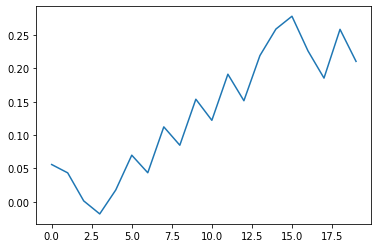

In [55]:
G0 = build_G(
    batch_size = BATCH_SIZE,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
)
seqs_random_et, seqs_random_ts = generate_sequences_gumbel(10, G0, BATCH_SIZE, T)
print(tf.argmax(seqs_random_et, axis=2))

ind = 1
x = np.arange(seqs_random_ts[ind,:,:].shape[0])
y = seqs_random_ts[ind,:,:]

plt.plot(x, y)

tf.Tensor(
[[1 3 0 0 2 0 2 1 2 3 0 1 0 3 2 2 0 3 0 3]
 [3 2 1 0 1 1 2 2 0 0 3 2 3 0 0 1 3 0 1 2]
 [3 2 1 2 1 3 2 1 3 1 2 2 3 1 3 2 0 3 1 2]
 [2 3 2 0 1 1 3 2 0 0 3 1 0 1 1 3 1 0 3 2]
 [0 3 0 2 2 0 0 3 1 3 2 2 3 2 0 1 2 0 2 3]
 [3 3 0 3 0 1 2 2 3 0 1 1 2 1 3 2 0 2 3 2]
 [2 1 0 2 2 2 3 0 1 0 2 1 3 0 1 3 0 2 3 0]
 [2 1 3 1 3 1 3 0 0 2 2 3 3 0 1 2 0 3 2 0]
 [3 3 2 1 2 2 0 3 1 2 2 0 1 2 2 0 0 1 2 0]
 [2 0 3 0 2 0 1 3 0 3 0 0 0 2 2 0 2 2 3 1]], shape=(10, 20), dtype=int64)


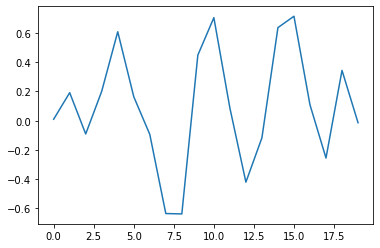

In [56]:
G1 = pretrained_generator
seqs_pretrained_et, seqs_pretrained_ts = generate_sequences_gumbel(10, G1, BATCH_SIZE, T)
print(tf.argmax(seqs_pretrained_et, axis=2))

ind = 1
x = np.arange(seqs_pretrained_ts[ind,:,:].shape[0])
y = seqs_pretrained_ts[ind,:,:]

plt.plot(x, y)

tf.Tensor(
[[1 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [2 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [2 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
 [0 2 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]], shape=(10, 20), dtype=int64)


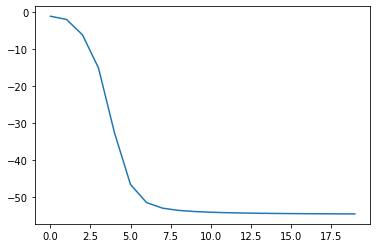

In [57]:
G2 = G
seqs_trained_et, seqs_trained_ts = generate_sequences_gumbel(10, G2, BATCH_SIZE, T)

print(tf.argmax(seqs_trained_et, axis=2))

ind = 3
x = np.arange(seqs_trained_ts[ind,:,:].shape[0])
y = seqs_trained_ts[ind,:,:]

plt.plot(x, y)

## Save trained G and D weights

In [ ]:
if not os.path.exists(model_save_dir + '/G_run_2021-03-27'):
    os.makedirs(model_save_dir + '/G_run_2021-03-27')

G_save_path = model_save_dir + '/G_run_2021-03-27/model.tf'
                
if not os.path.exists(model_save_dir + '/D_run_2021-03-27'):
    os.makedirs(model_save_dir + '/D_run_2021-03-27')

D_save_path = model_save_dir + '/D_run_2021-03-27/model.tf'

G.save_weights(G_save_path)
D.save_weights(D_save_path)